In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io
import itertools
from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
AA_hotspots_df = pl.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_AA_hotspots.csv",
    null_values="NA",
).rename({
    "Chromosome": "chrom", 
    "Motif_Centre_Pos": "motif_center_pos",
    "Start_Pos": "hotspot_start_pos",
    "End_Pos": "hotspot_end_pos",    
})

In [6]:
CL4_hotspots_df = pl.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_CL4_hotspots.csv",
    null_values="NA",
    separator=" ",
).rename({
    "Chromosome": "chrom", 
    "Motif_Centre_Pos": "motif_center_pos",
    "Start_Pos": "hotspot_start_pos",
    "End_Pos": "hotspot_end_pos",        
})

# Sample IDs

In [7]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]



In [8]:
# Samples to do
sample_id_to_age = {
    "PD50477f": 74,
    "PD50519d": 36,
    "PD50508f": 74,
    "PD50523b": 26,
    "PD50521b": 27,
    "PD50508b": 62,
    "PD46180c": 24,
    "PD50521e": 40,
    "PD50489e": 47,
}



In [260]:
read_blacklist = \
['m64230e_220906_003948/60032580/ccs',
 'm64178e_220829_002441/25232978/ccs',
 'm64094e_220917_231317/155059512/ccs',
 'm64178e_220829_002441/62392396/ccs',
 'm64094e_220917_231317/96076942/ccs',
 'm64094e_220917_231317/74517145/ccs',
 'm64230e_220906_003948/52166986/ccs',
 'm64230e_220906_003948/11666271/ccs',
 'm64222e_220804_013319/56297546/ccs',
 'm64222e_220804_013319/41749151/ccs',
 'm64222e_220804_013319/45547932/ccs',
 'm64221e_220814_084225/164430634/ccs',
 'm64222e_220804_013319/43976808/ccs',
 'm64222e_220804_013319/47317891/ccs',
 'm64221e_220814_084225/86903563/ccs',
 'm64222e_220804_013319/22283946/ccs',
 'm64222e_220804_013319/116720068/ccs',
 'm64221e_220811_133409/30083306/ccs',
 'm64221e_220811_133409/86312411/ccs',
 'm64221e_220811_133409/57606928/ccs',
 'm64221e_220814_084225/42402180/ccs',
 'm64221e_220811_133409/156237854/ccs',
 'm64221e_220814_084225/135531048/ccs',
 'm64221e_220814_084225/61933374/ccs',
 'm64222e_220804_013319/52035891/ccs',
 'm64222e_220804_013319/24119431/ccs',
 'm64221e_220814_084225/130549150/ccs',
 'm64178e_220827_132801/55773773/ccs',
 'm64229e_220913_234845/18483464/ccs',
 'm64229e_220911_015559/67109081/ccs',
 'm64229e_220913_234845/165741700/ccs',
 'm64016e_220903_004635/179570014/ccs',
 'm64229e_220911_015559/178128607/ccs',
 'm64229e_220911_015559/38471137/ccs',
 'm64016e_220901_135237/110952989/ccs',
 'm64229e_220909_150132/99681901/ccs',
 'm64016e_220901_135237/21825066/ccs',
 'm64016e_220905_200242/98240161/ccs',
 'm64016e_220905_200242/149489318/ccs',
 'm64016e_220905_200242/108399242/ccs',
 'm64178e_220824_153720/138807483/ccs',
 'm64178e_220824_153720/179045405/ccs',
 'm64016e_220904_102424/137364734/ccs',
 'm64178e_220824_153720/160629818/ccs',
 'm64221e_220812_230038/113836394/ccs',
 'm64221e_220812_230038/1574852/ccs',
 'm64222e_220805_105329/39323876/ccs',
 'm64016e_220816_095555/81068543/ccs',
 'm64094e_220717_002414/66063090/ccs',
 'm64174e_220620_110709/129172237/ccs',
 'm64174e_220620_110709/60883267/ccs',
 'm64174e_220620_110709/62392404/ccs',
 'm64174e_220620_110709/56298290/ccs',
 'm64094e_220717_002414/82709011/ccs',
 'm64094e_220717_002414/129368391/ccs',
 'm64094e_220715_151527/7865396/ccs',
 'm64094e_220715_151527/8653118/ccs',
 'm64094e_220715_151527/161155192/ccs',
 'm64094e_220717_002414/110496448/ccs',
 'm64174e_220620_110709/104661259/ccs',
 'm64094e_220717_002414/20055042/ccs']

In [262]:
basic_filtering = \
    (~pl.col("has_common_transition")) & \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10) & \
    (~pl.col("read_name").is_in(read_blacklist))

# Study hotspots and DSB maps

In [263]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])


In [264]:
trusty_cls_df = (cls_df
    .filter(basic_filtering)
)

very_trusty_cls_df = trusty_cls_df.filter(extra_filtering)

In [265]:
cls_df

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom,sample_id
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,str
"""m64094e_220917…",16141,2,"[10, 13]","[668, 1500, … 14850]","""GC""",0,4,4,4,0,0,5,8,60,60,false,false,true,"""chr1_RagTag""","""PD50477f"""
"""m64178e_220829…",15496,4,"[25, 26, … 52]","[696, 801, … 14890]","""CNCO""",0,29,24,15,0,0,12,23,60,60,false,false,true,"""chr1_RagTag""","""PD50477f"""
"""m64178e_220829…",11785,1,[0],"[2238, 6808, … 11062]","""ambiguous""",0,1,1,0,0,0,4,4,60,60,true,true,true,"""chr1_RagTag""","""PD50477f"""
"""m64178e_220829…",12843,3,"[22, 23, 25]","[1366, 1425, … 11006]","""CNCO""",194,20,17,7,885,1,16,12,60,60,false,false,false,"""chr1_RagTag""","""PD50477f"""
"""m64094e_220917…",19104,2,"[21, 22]","[2424, 2638, … 17545]","""GC""",0,3,3,10,0,0,10,9,60,60,false,false,false,"""chr1_RagTag""","""PD50477f"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m64094e_220715…",11455,3,"[24, 26, 27]","[1104, 1607, … 9081]","""CNCO""",57,1,1,4,2305,1,17,7,60,52,false,false,true,"""chr22_RagTag""","""PD50489e"""
"""m64174e_220620…",9254,8,"[0, 3, … 14]","[609, 1174, … 8582]","""CNCO""",332,242,25,20,3,1,5,7,60,60,true,true,true,"""chr22_RagTag""","""PD50489e"""
"""m64174e_220620…",20284,2,"[1, 2]","[12611, 12770, … 15998]","""GC""",125,363,47,52,0,0,4,4,4,60,false,false,true,"""chr22_RagTag""","""PD50489e"""


In [266]:
def annotate_with_cM_bam_parquet(
    focal_sample_id, 
    chrom, 
    bam_filename, 
    parquet_filename,
    readlist_filename=None,
    rate_maps=None, 
    cls_df=None,
    AA_hotspots_df=None,
    CL4_hotspots_df=None,
):
    candidates_df = pl.read_parquet(parquet_filename)

    # try:
    rows = []
    for aln in pysam.AlignmentFile(bam_filename).fetch():
        rows.append([aln.query_name, aln.reference_start, aln.reference_end, aln.mapping_quality, aln.query_length])

    rows_df = pl.DataFrame(rows, schema=["read_name", "start_pos_0based", "end_pos_0based", "mapq", "read_length"])

    if rate_maps is not None:
        rate_map = rate_maps[chrom]
        start_poses_cm = rate_map.get_cumulative_mass(rows_df["start_pos_0based"]) * 1e2
        end_poses_cm = rate_map.get_cumulative_mass(rows_df["end_pos_0based"]) * 1e2
    else:    
        start_poses_cm = np.full(len(rows_df), np.nan)
        end_poses_cm = np.full(len(rows_df), np.nan) 

    # Apparently get_cumulative_mass results are in Morgan
    cM = (end_poses_cm - start_poses_cm)

    prob_CO = scipy.stats.poisson.sf(0, cM * 0.01)    

    rows_df = rows_df.with_columns(
        start_pos_cM = start_poses_cm,
        cM = cM,
        prob_CO = prob_CO,
        cM_per_bp_across_read = cM / pl.col("read_length"),
    )
    
    if readlist_filename is not None:
        candidates_df = (candidates_df
            .join(
                pl.read_csv(readlist_filename, new_columns=["read_name"]),
                on="read_name",
            )
        )

    annotated_df = (candidates_df
        .join(rows_df, on="read_name", how="left")
        .with_columns(
            sample_id = pl.lit(focal_sample_id),
            chrom = pl.lit(chrom),            
        )
    )
    
    # Annotate hotspots with respect to the whole read
    if AA_hotspots_df is not None:
        AA_hotspots_df = (AA_hotspots_df
            .filter(pl.col("chrom") == chrom)
            .sort("motif_center_pos")
            .set_sorted("motif_center_pos")
        )
        
        AA_possible_hits = (annotated_df
            .select("read_name", "start_pos_0based", "end_pos_0based")
            .sort("start_pos_0based")
            .set_sorted("start_pos_0based")
            .join_asof(
                AA_hotspots_df.select(
                    AA_motif_center_pos=pl.col("motif_center_pos"), 
                    AA_heat=pl.col("heat"),
                    AA_motif_strand=pl.col("motif_strand"),
                ),
                left_on="start_pos_0based",
                right_on="AA_motif_center_pos",
                strategy="forward",
            )
            .filter((pl.col("AA_motif_center_pos") >= pl.col("start_pos_0based")) & 
                    (pl.col("AA_motif_center_pos") < pl.col("end_pos_0based")))
            .select("read_name", "AA_motif_center_pos", "AA_heat", "AA_motif_strand")
        )
        
        annotated_df = (annotated_df
            .join(
                AA_possible_hits, 
                on="read_name",
                how="left",
            )
        )
        
    if CL4_hotspots_df is not None:
        CL4_hotspots_df = (CL4_hotspots_df
            .filter(pl.col("chrom") == chrom)
            .sort("motif_center_pos")
            .set_sorted("motif_center_pos")
        )
        
        CL4_possible_hits = (annotated_df
            .select("read_name", "start_pos_0based", "end_pos_0based")
            .sort("start_pos_0based")
            .set_sorted("start_pos_0based")
            .join_asof(
                CL4_hotspots_df.select(
                    CL4_motif_center_pos=pl.col("motif_center_pos"), 
                    CL4_heat=pl.col("heat"),
                    CL4_motif_strand=pl.col("motif_strand"),
                ),
                left_on="start_pos_0based",
                right_on="CL4_motif_center_pos",
                strategy="forward",
            )
            .filter((pl.col("CL4_motif_center_pos") >= pl.col("start_pos_0based")) & 
                    (pl.col("CL4_motif_center_pos") < pl.col("end_pos_0based")))
            .select("read_name", "CL4_motif_center_pos", "CL4_heat", "CL4_motif_strand")
        )
        
        annotated_df = (annotated_df
            .join(
                CL4_possible_hits, 
                on="read_name",
                how="left",
            )
        )
    
    if cls_df is not None:
        # Add classification information
        annotated_df = annotated_df.join(
            cls_df.rename({"chrom": "chrom_denovo"}), 
            on=["read_name", "sample_id"], 
            how="left"
        )
        
        # Use that to narrow the cM range
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
                active_end_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
            )
            .with_columns(
                active_region_length = pl.col("active_end_pos") - pl.col("active_start_pos"),                
            )
        )
        
        if rate_maps is not None:
            rate_map = rate_maps[chrom]
            active_start_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_start_pos"]) * 1e2
            active_end_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_end_pos"]) * 1e2
        else:    
            active_start_poses_cm = np.full(len(annotated_df), np.nan)
            active_end_poses_cm = np.full(len(annotated_df), np.nan) 

        active_cM = (active_end_poses_cm - active_start_poses_cm)
        
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos_cM = active_start_poses_cm,
                active_end_pos_cM = active_end_poses_cm,
                active_cM = (active_end_poses_cm - active_start_poses_cm),
                cM_per_bp_across_active = (active_end_poses_cm - active_start_poses_cm) / pl.col("active_region_length"),
            )
        )
        
        if AA_hotspots_df is not None:
            annotated_df = (annotated_df
                .with_columns(
                    AA_hotspot_in_active = (
                        (pl.col("active_start_pos") <= pl.col("AA_motif_center_pos")) & \
                        (pl.col("active_end_pos") > pl.col("AA_motif_center_pos"))
                    )
                )
            )
        if CL4_hotspots_df is not None:
            annotated_df = (annotated_df
                .with_columns(
                    CL4_hotspot_in_active = (
                        (pl.col("active_start_pos") <= pl.col("CL4_motif_center_pos")) & \
                        (pl.col("active_end_pos") > pl.col("CL4_motif_center_pos"))
                    )
                )
            )
        
            
    
    return annotated_df

def annotate_with_cM_grch37(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch37.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = annotate.rate_maps,
        cls_df = cls_df,
    )

def annotate_with_cM_grch38(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch38.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = None,
        cls_df = cls_df,
        AA_hotspots_df = AA_hotspots_df,
        CL4_hotspots_df = CL4_hotspots_df,
    )

def annotate_with_cM_T2T(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_T2T.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename,
        rate_maps = None,
        cls_df = cls_df,
    )

def annotate_with_cM_grch37_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.aligned_to_grch37.bam"
    
    candidates_readlist_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.read_names_grch37.txt"    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        readlist_filename = candidates_readlist_filename,
        rate_maps = annotate.rate_maps,
        cls_df = None,
    )

def annotate_with_cM_grch38_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.aligned_to_grch38.bam"
    
    candidates_readlist_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.read_names_grch38.txt"    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        readlist_filename = candidates_readlist_filename,
        rate_maps = None,
        cls_df = None,
        AA_hotspots_df = AA_hotspots_df,
        CL4_hotspots_df = CL4_hotspots_df,
    )

In [267]:
all_annotated_candidates_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch37)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_grch37(focal_sample_id, chrom) 
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1925433415743022s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 191 out of 198 | elapsed:    9.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    9.8s fini

In [268]:
all_annotated_candidates_grch38_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch38)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_grch38(focal_sample_id, chrom) 
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1550295352935791s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 191 out of 198 | elapsed:    5.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    6.1s finished


In [269]:
all_annotated_candidates_T2T_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_T2T)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_T2T(focal_sample_id, chrom) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13997983932495117s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 191 out of 198 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    4.1s finished


In [270]:
all_annotated_random_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch37_random)(focal_sample_id, chrom) 
                for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

all_annotated_random_df = all_annotated_random_df.drop_nulls()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

In [271]:
all_annotated_random_grch38_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch38_random)(focal_sample_id, chrom) 
                for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

#all_annotated_random_grch38_df = all_annotated_random_grch38_df.drop_nulls()

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_grch38_random(focal_sample_id, chrom) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

In [272]:
filtered_annotated_candidates_df_expanded = all_annotated_candidates_df.filter(basic_filtering & extra_filtering)
filtered_annotated_candidates_grch38_df_expanded = all_annotated_candidates_grch38_df.filter(basic_filtering & extra_filtering)
filtered_annotated_candidates_T2T_df_expanded = all_annotated_candidates_T2T_df.filter(basic_filtering & extra_filtering)

## cM vs. candidate reads

<Axes: ylabel='Count'>

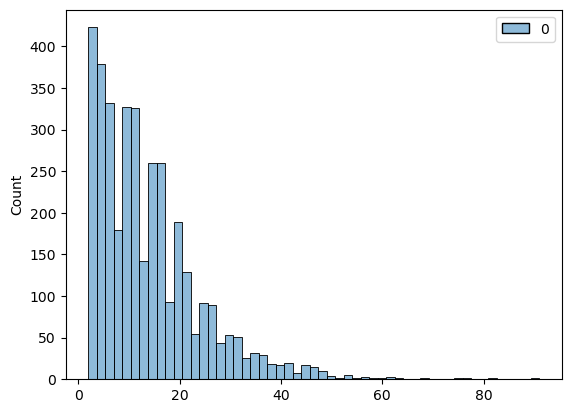

In [273]:
sns.histplot(
    very_trusty_cls_df.select(pl.col("snp_positions_on_read").list.len()),
)

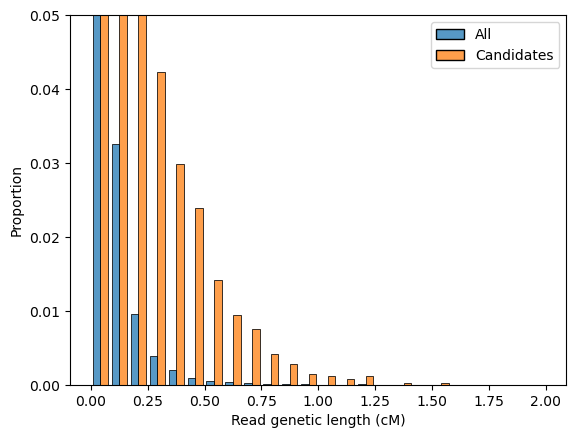

In [274]:
sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded["cM"], name="Candidates"),
    ], 
    bins=np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
plt.ylim(0,0.05);
plt.xlabel("Read genetic length (cM)");


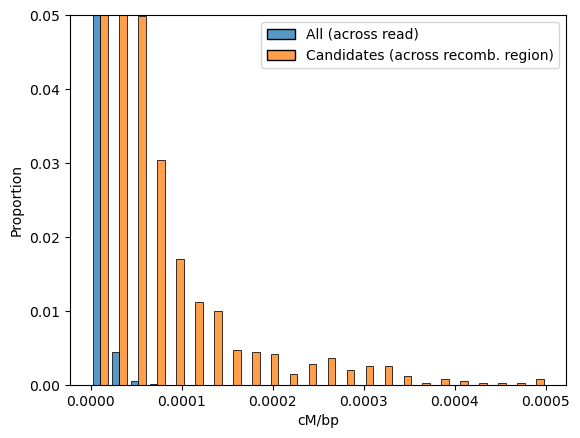

In [275]:
sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All (across read)"),
        pd.Series(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"], name="Candidates (across recomb. region)"),
    ], 
    bins=np.linspace(0, 0.0005, 25), #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
plt.ylim(0,0.05);
plt.xlabel("cM/bp");


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


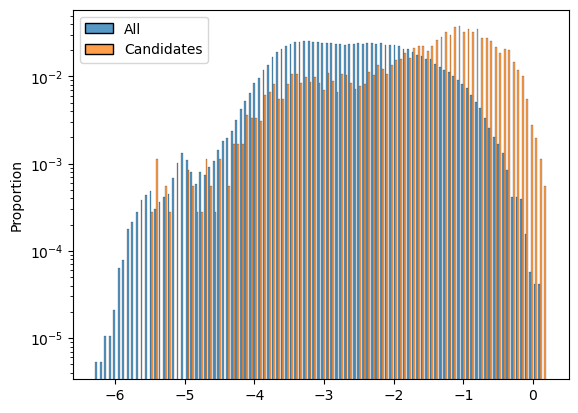

In [276]:
sns.histplot(
    [
        pd.Series(np.log10(all_annotated_random_df["cM"]), name="All"),
        pd.Series(np.log10(filtered_annotated_candidates_df_expanded["cM"]), name="Candidates"),
    ], 
#    bins=np.linspace(0, 2, 25),
    bins=100,
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

plt.yscale("log");

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


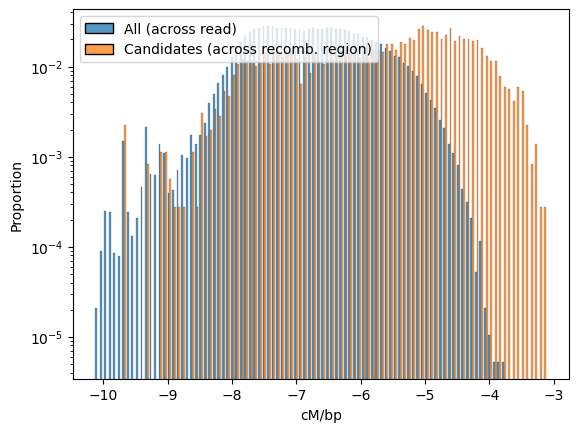

In [277]:
sns.histplot(
    [
        pd.Series(np.log10(all_annotated_random_df["cM_per_bp_across_read"]), name="All (across read)"),
        pd.Series(np.log10(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"]), name="Candidates (across recomb. region)"),
    ], 
    bins=100, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("cM/bp");


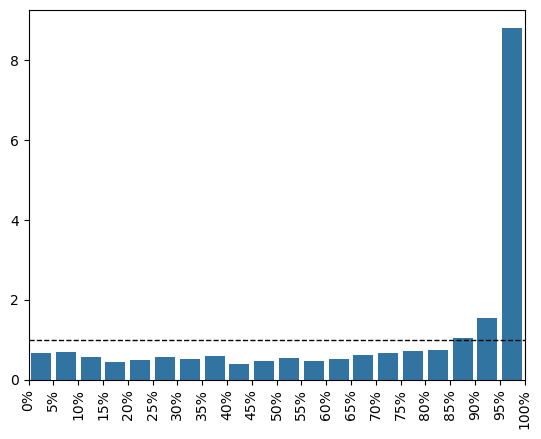

In [25]:
n_bins = 21



bins = np.linspace(0,1,n_bins)
qs = np.quantile(all_annotated_random_df["cM_per_bp_across_read"], q=bins)
y = np.histogram(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"], bins=qs)[0]
y = y / y.sum()
sns.barplot(
    x = bins[:-1],
    y = y/(1/n_bins), 
)
plt.axhline(1, lw=1, c="black", ls="--");


plt.xticks(ticks=np.arange(n_bins)-0.5, labels=[f"{int(x*100)}%" for x in bins], rotation=90);

<Axes: >

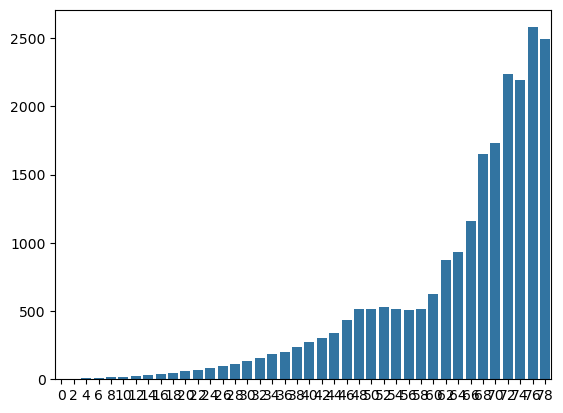

In [26]:
x = np.arange(0,80,2)

cm_thresholds = all_annotated_random_df["cM_per_bp_across_read"].mean() * x

ratios = [(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"]>T).mean() / (all_annotated_random_df["cM_per_bp_across_read"]>T).mean() for T in cm_thresholds]



sns.barplot(
    x=x, 
    y=ratios,
)


In [27]:
# plt.plot(trusty_cls_df["total_mismatches"].value_counts().sort("total_mismatches").head(50)["count"], '.')
# plt.plot(trusty_cls_df["total_common_insertions"].value_counts().sort("total_common_insertions").head(50)["count"], '.')
# plt.plot(trusty_cls_df["total_clipping"].value_counts().sort("total_clipping").head(50)["count"], '.')
# plt.yscale("log")

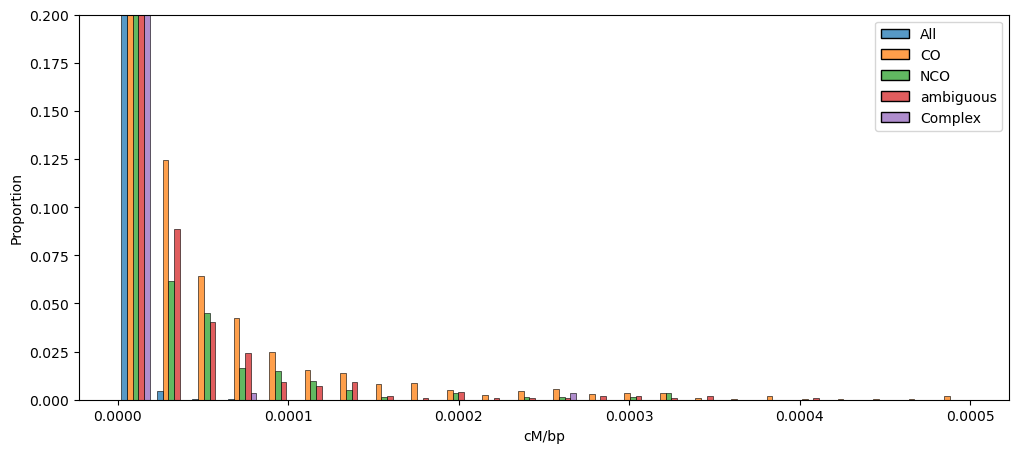

In [28]:
fig, ax = plt.subplots(figsize=(12,5))

sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM_per_bp_across_active"], name="CO"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"], name="NCO"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "ambiguous")["cM_per_bp_across_active"], name="ambiguous"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CNCO")["cM_per_bp_across_active"], name="Complex"),
    ], 
    bins=np.linspace(0, 0.0005, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_ylim(0, 0.2);
ax.set_xlabel("cM/bp");

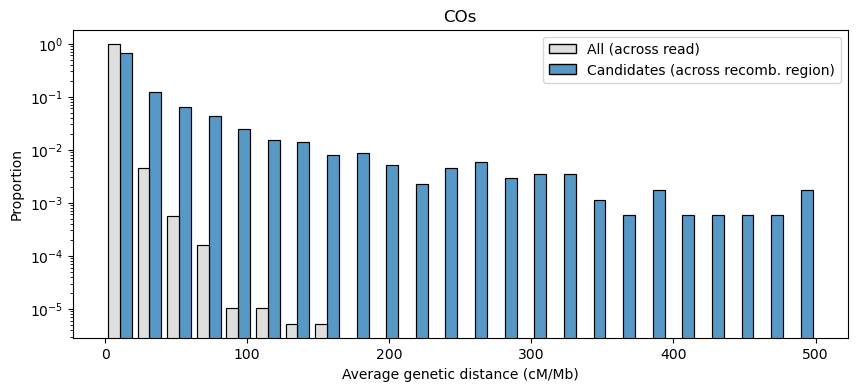

In [29]:
fig, ax = plt.subplots(figsize=(10,4))

sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All (across read)") * 1e6,
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM_per_bp_across_active"], name="Candidates (across recomb. region)") * 1e6,
    ], 
    bins=np.linspace(0, 0.0005, 25) * 1e6, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    palette=["lightgrey", "C0"],
    ax=ax,
)

plt.yscale("log");
#plt.ylim(0,0.1);
plt.xlabel("Average genetic distance (cM/Mb)");
plt.title("COs");

In [30]:
A = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM_per_bp_across_active"]*1e6)
B = (all_annotated_random_df["cM_per_bp_across_read"]*1e6)
print(A.mean(), B.mean())
print(scipy.stats.ks_2samp(A, B))

32.215176613550334 1.1702866972940826
KstestResult(statistic=0.5457908470545574, pvalue=0.0, statistic_location=2.161154398054632, statistic_sign=-1)


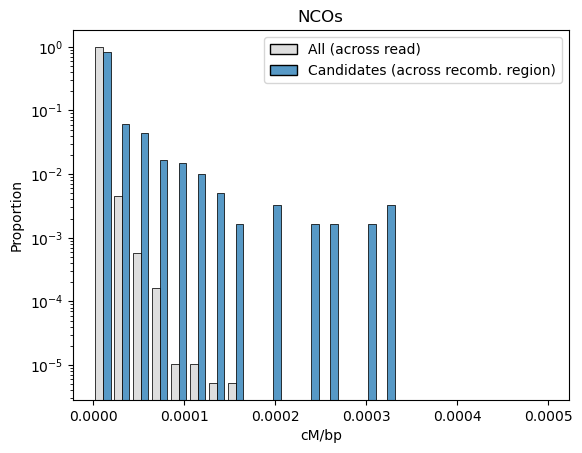

In [31]:
sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All (across read)"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"], name="Candidates (across recomb. region)"),
    ], 
    bins=np.linspace(0, 0.0005, 25), #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    palette=["lightgrey", "C0"],    
)

plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("cM/bp");
plt.title("NCOs");

In [32]:
A = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"]*1e6)
B = (all_annotated_random_df["cM_per_bp_across_read"]*1e6)
print(A.mean(), B.mean())
print(scipy.stats.ks_2samp(A, B))

15.170662483977516 1.1702866972940826
KstestResult(statistic=0.324656823671826, pvalue=6.3716118008866356e-58, statistic_location=2.8891302399407954, statistic_sign=-1)


In [33]:
A = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"]*1e6)
B = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM_per_bp_across_active"]*1e6)
print(A.mean(), B.mean())
print(scipy.stats.ks_2samp(A, B))

15.170662483977516 32.215176613550334
KstestResult(statistic=0.2271600965106956, pvalue=4.585116907099097e-21, statistic_location=2.138582803288775, statistic_sign=1)


In [34]:
A = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "ambiguous")["cM_per_bp_across_active"]*1e6)
B = (filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"]*1e6)
print(A.mean(), B.mean())
print(scipy.stats.ks_2samp(A, B))

18.220404930060738 15.170662483977516
KstestResult(statistic=0.05983350013067563, pvalue=0.12193846808900513, statistic_location=0.30823799997537116, statistic_sign=-1)


## CO vs NCO

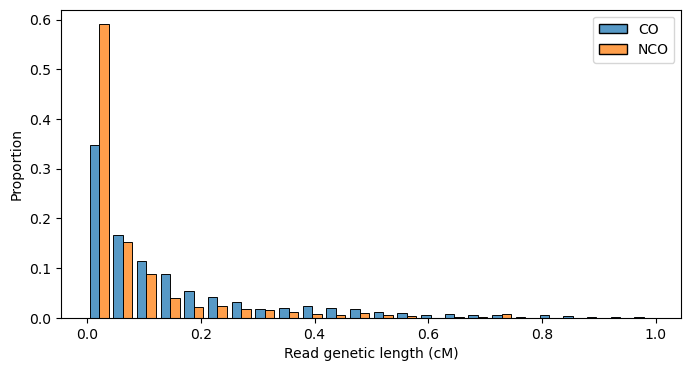

In [35]:
fig, ax = plt.subplots(figsize=(8,4))

sns.histplot(
    [
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM"], name="CO"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM"], name="NCO"),
    ], 
    bins=np.linspace(0, 1, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.2);
plt.xlabel("Read genetic length (cM)");


In [36]:
scipy.stats.ks_2samp(
    filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM"],
    filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM"],
)

KstestResult(statistic=0.24566883139834472, pvalue=1.344218566836982e-24, statistic_location=0.02512572111999134, statistic_sign=-1)

### Per sample?

In [37]:
rows = []
for sample_id in sorted(sample_ids):
    x = filtered_annotated_candidates_df_expanded.filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "CO"))["cM"]
    y = filtered_annotated_candidates_df_expanded.filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "GC"))["cM"]

    rows.append((sample_id, scipy.stats.ks_2samp(x, y).pvalue, inference.permutation_testing([[x,y]], n_perms=10000, method="AD")))

per_sample_df = pl.DataFrame(rows, schema=["sample_id", "ks_pvalue", "perm_pvalue"])

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:581: UserWarning: p-value floored: true value smaller than 0.001
  test_statistic = lambda x,y: scipy.stats.anderson_ksamp([x, y]).statistic
/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:581: UserWarning: p-value capped: true value larger than 0.25
  test_statistic = lambda x,y: scipy.stats.anderson_ksamp([x, y]).statistic


In [38]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(
        pl.DataFrame(sorted(sample_ids), schema=["sample_id"]).join(
            filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["sample_id"].value_counts().rename({"count": "CO_count"}),
            on="sample_id",
            how="left",
        ).join(
            filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["sample_id"].value_counts().rename({"count": "NCO_count"}),
            on="sample_id",
            how="left",
        )
        .join(
            per_sample_df,
            on="sample_id",
            how="left",
        )
    )

sample_id,CO_count,NCO_count,ks_pvalue,perm_pvalue
str,u32,u32,f64,f64
"""PD46180c""",261,74,0.000002,0.0
"""PD50477f""",202,75,0.000022,0.0
"""PD50489e""",180,53,0.000236,0.0
"""PD50508b""",161,46,0.000289,0.0
"""PD50508f""",130,31,0.008751,0.0016
"""PD50519d""",177,85,1.6732e-9,0.0
"""PD50521b""",233,91,0.000177,0.0
"""PD50521e""",199,74,0.017215,0.0059
"""PD50523b""",208,85,0.816607,0.6786


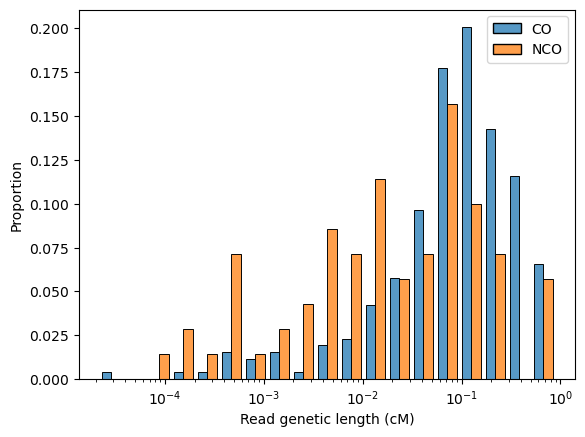

In [39]:
sample_id = "PD46180c"

x = filtered_annotated_candidates_df_expanded.filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "CO"))["cM"]
y = filtered_annotated_candidates_df_expanded.filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "GC"))["cM"]

sns.histplot(
    [
        pd.Series(x, name="CO"),
        pd.Series(y, name="NCO"),
    ], 
    #bins=np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    log_scale=True,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Read genetic length (cM)");


### Per chromosome?

In [150]:
rows = []
for chrom in aut_chrom_names:
    x = filtered_annotated_candidates_df_expanded.filter((pl.col("chrom") == chrom) & (pl.col("class") == "CO"))["cM"]
    y = filtered_annotated_candidates_df_expanded.filter((pl.col("chrom") == chrom) & (pl.col("class") == "GC"))["cM"]

    rows.append((chrom, scipy.stats.ks_2samp(x, y).pvalue, inference.permutation_testing([[x,y]], n_perms=10000, method="AD")))
    
per_chrom_df = pl.DataFrame(rows, schema=["chrom", "ks_pvalue", "perm_pvalue"])

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:581: UserWarning: p-value floored: true value smaller than 0.001
  test_statistic = lambda x,y: scipy.stats.anderson_ksamp([x, y]).statistic
/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:581: UserWarning: p-value capped: true value larger than 0.25
  test_statistic = lambda x,y: scipy.stats.anderson_ksamp([x, y]).statistic


In [151]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(
        pl.DataFrame(aut_chrom_names, schema=["chrom"]).join(
            filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["chrom"].value_counts().rename({"count": "CO_count"}),
            on="chrom",
            how="left",
        ).join(
            filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["chrom"].value_counts().rename({"count": "NCO_count"}),
            on="chrom",
            how="left",
        )
        .join(
            per_chrom_df,
            on="chrom",
            how="left",
        )
    )

chrom,CO_count,NCO_count,ks_pvalue,perm_pvalue
str,u32,u32,f64,f64
"""chr1""",127,44,0.000158,0.0
"""chr2""",127,39,0.000211,0.0007
"""chr3""",113,52,0.00003,0.0
"""chr4""",89,37,0.307136,0.3133
"""chr5""",93,37,0.008244,0.0009
"""chr6""",103,36,0.006628,0.001
"""chr7""",96,33,0.227943,0.0622
"""chr8""",80,30,0.000241,0.0001
"""chr9""",80,37,0.019308,0.0036


### Distance from telomeres?

In [152]:
all_poses_df = (filtered_annotated_candidates_df_expanded
    .join(
        very_trusty_cls_df.select("read_name"), 
        on="read_name",
    )
    .select(
        "read_name",
        "sample_id",
        "chrom",
        "class",
        "start_pos_0based",
        "cM",
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("snp_before"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0) + 1).alias("snp_after"),
    )
    .with_columns(
        (pl.col("start_pos_0based") + (pl.col("snp_after") - pl.col("snp_before"))//2).alias("pos_average"),
    )
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    )
    .with_columns(
        dist_from_end = pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        )
    )
)

In [153]:
rows = []

step = 1e7

for dist in tqdm.tqdm(np.arange(10)):
    x = all_poses_df.filter((pl.col("dist_from_end") // step == dist) & (pl.col("class") == "CO"))["cM"]
    y = all_poses_df.filter((pl.col("dist_from_end") // step == dist) & (pl.col("class") == "GC"))["cM"]

    rows.append((dist*step, len(x), len(y), scipy.stats.ks_2samp(x, y).pvalue, inference.permutation_testing([[x,y]], n_perms=10000, method="AD")))
    
per_dist_df = pl.DataFrame(rows, schema=["dist", "count_CO", "count_NCO", "ks_pvalue", "perm_pvalue"])

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


In [154]:
per_dist_df

dist,count_CO,count_NCO,ks_pvalue,perm_pvalue
f64,i64,i64,f64,f64
0.0,652,191,5.0295e-8,0.0
1e7,295,85,0.000125,0.0
2e7,220,74,0.000154,0.0
3e7,150,65,0.001014,0.0
4e7,91,50,0.000058,0.0
5e7,80,27,0.004308,0.002
6e7,72,38,0.079198,0.0332
7e7,50,23,0.127945,0.0924
8e7,49,17,0.014517,0.0085


## Hotspots vs. candidate reads

In [155]:
all_annotated_random_grch38_df.select(pl.col("AA_motif_center_pos").is_not_null())["AA_motif_center_pos"].value_counts()

AA_motif_center_pos,count
bool,u32
false,170838
true,26964


In [156]:
27301/(27301+170501)

0.13802186024408247

In [157]:
(~filtered_annotated_candidates_grch38_df_expanded.filter(pl.col("class") == "CO")["AA_motif_center_pos"].is_null()).value_counts()

AA_motif_center_pos,count
bool,u32
false,605
true,1146


In [158]:
1157/(1157+622)

0.6503653738055087

In [159]:
scipy.stats.fisher_exact([[622, 1157], [170501, 27301]])

SignificanceResult(statistic=0.08608126692286995, pvalue=0.0)

In [160]:
(~filtered_annotated_candidates_grch38_df_expanded.filter(pl.col("class") == "GC")["AA_motif_center_pos"].is_null()).value_counts()

AA_motif_center_pos,count
bool,u32
false,310
true,304


In [161]:
319/(319+350)

0.476831091180867

In [162]:
scipy.stats.fisher_exact([[622, 1157], [319, 350]])

SignificanceResult(statistic=0.5898402256403031, pvalue=1.1943113035560967e-08)

In [163]:
(filtered_annotated_candidates_grch38_df_expanded
    .filter(pl.col("class") == "CO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
    ["AA_hotspot_in_active"].value_counts()
)

AA_hotspot_in_active,count
bool,u32
false,518
true,628


In [164]:
632/(632+525)

0.5462402765773552

In [165]:
(filtered_annotated_candidates_grch38_df_expanded
    .filter(pl.col("class") == "GC")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
    ["AA_hotspot_in_active"].value_counts()
)

AA_hotspot_in_active,count
bool,u32
false,115
true,189


In [166]:
193/(193+126)

0.6050156739811913

In [167]:
scipy.stats.fisher_exact([[126,193],[525,632]])

SignificanceResult(statistic=0.7859067357512953, pvalue=0.06486034366563027)

In [168]:
dists_df = (filtered_annotated_candidates_grch38_df_expanded
    .filter(pl.col("class") == "CO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
    .select(
        pl.max_horizontal(
            pl.max_horizontal(
                pl.col("active_start_pos") - pl.col("AA_motif_center_pos"),
                pl.lit(0)
            ),
            pl.max_horizontal(
                pl.col("AA_motif_center_pos") - pl.col("active_end_pos"),
                pl.lit(0)
            ))
        .alias("dist_motif_to_active")
    )
)

<Axes: ylabel='Proportion'>

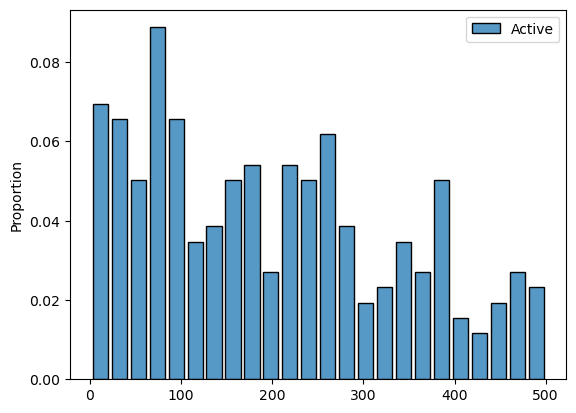

In [169]:
sns.histplot(
    [
        pd.Series(dists_df["dist_motif_to_active"], name="Active"),
    ], 
    bins=np.linspace(1, 500, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
#plt.xlabel("cM/bp");
#plt.title("complex");

# What is the expected number of detected COs?

## Add high-quality SNP data for the random reads

In [170]:
def runme(focal_sample_id, chrom):
    snps_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
    )

    frac_df = (snps_df
        .join(all_annotated_random_df, on="read_name")
        .filter(pl.col("is_high_quality_snp"))   # Not mid - because this is for detection
        .group_by("read_name")
        .agg(
            pl.col("length").len().alias("n_snps"),
            pl.col("start").first().alias("first_snp"),
            pl.col("start").last().alias("last_snp"),
            pl.col("read_length1").mean().alias("read_length"),
        )
        .select(
            "read_name",
            "n_snps",
            frac_detectable=(pl.col("last_snp") - pl.col("first_snp")) / pl.col("read_length"),
        )
    )

    return frac_df

frac_dfs = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(focal_sample_id, chrom)
        for focal_sample_id in sample_ids for chrom in aut_chrom_names
)

all_frac_df = pl.concat(frac_dfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.7min
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Par

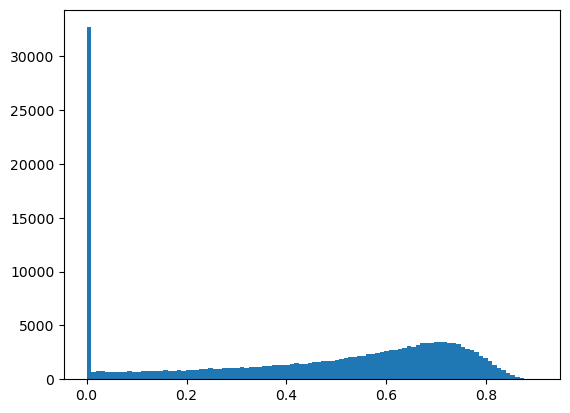

In [171]:
plt.hist(all_frac_df["frac_detectable"], bins=100);

In [172]:
(all_frac_df["frac_detectable"] == 0).mean()

0.1702400068283783

In [173]:
all_frac_df["frac_detectable"].mean()

0.44062482566626565

## Get number of reads

In [174]:
# read_numbers = {}

# ccs_read_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/")

# for sample_id in sample_ids:
#     count_path = ccs_read_path / sample_id / (sample_id + ".ccs.filtered.fastqc")
#     d = open(count_path).read().strip().split()
#     read_numbers[sample_id] = int(d[1])


In [175]:
rows = []

def runme(focal_sample_id, chrom):
    all_reads_df = pl.scan_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet"
    )

    n_reads = (all_reads_df
        .filter(
            (pl.col("mapq1") >= 60) & \
            (pl.col("mapq2") >= 60) & \
            (pl.col("is_forward1") == pl.col("is_forward2"))
        )
        .filter(extra_filtering)
        .unique("read_name")
    ).select(pl.len()).collect(streaming=True).item()

    return [focal_sample_id, chrom, n_reads]

rows = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(focal_sample_id, chrom) for focal_sample_id in sample_ids for chrom in aut_chrom_names
)

filtered_read_counts_df = pl.DataFrame(rows, schema=["sample_id", "chrom", "n_reads"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

In [176]:
filtered_read_numbers = dict(list(filtered_read_counts_df.group_by("sample_id").agg(pl.col("n_reads").sum()).iter_rows()))

## Calculate coverage statistics

In [177]:
def calc_coverage_stats(
    focal_sample_id,
    chrom,
):
    filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / f"{focal_sample_id}.{chrom}_RagTag.hapintersection.minimap2.sorted.primary_alignments.hifiasm_haplotagged_0.95.coverage.bedgraph"
    
    df = pl.scan_csv(
        filename, 
        separator="\t", 
        new_columns=[
            "chrom1", 
            "start1", 
            "end1", 
            "coverage1",
            "chrom2", 
            "start2", 
            "end2", 
            "coverage2",
            "interval_length"
        ]
    )
    
    cov_df = (df
        .with_columns(
            coverage = pl.min_horizontal(pl.col("coverage1"), pl.col("coverage2"))
        )
        .group_by("coverage")
        .agg(pl.col("interval_length").sum())
        .sort("coverage")
    )
    
    return cov_df.collect(streaming=True)
         

In [178]:
def runme(sample_id, chrom):
    cov_df = calc_coverage_stats(sample_id, chrom)
    covered_total = cov_df.filter(pl.col("coverage") >= 3)["interval_length"].sum()
    total = cov_df.filter(pl.col("coverage") >= 1)["interval_length"].sum()
    return [sample_id, chrom, covered_total, total]


rows = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(sample_id, chrom) \
        for sample_id in sample_ids \
        for chrom in aut_chrom_names 
)

covered_df = pl.DataFrame(rows, schema=["sample_id", "chrom", "covered_total", "total"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

In [179]:
covered_ratio_df = (covered_df
    .group_by("sample_id")
    .agg(
        pl.col("covered_total").sum(), 
        pl.col("total").sum(),
    )
    .select(
        "sample_id",
        covered_ratio = pl.col("covered_total") / pl.col("total"),
    )
)

display(covered_ratio_df)

sample_id,covered_ratio
str,f64
"""PD50519d""",0.878742
"""PD50521e""",0.877108
"""PD50508f""",0.83398
"""PD50489e""",0.853572
"""PD50477f""",0.905496
"""PD50521b""",0.928474
"""PD46180c""",0.930224
"""PD50508b""",0.895826
"""PD50523b""",0.908319


## Calculate expected

In [180]:
expected_df = (all_annotated_random_df
    .join(all_frac_df, on="read_name")
    .select(
        "sample_id", 
        "chrom",
        prob_detected_CO = pl.col("frac_detectable") * pl.col("prob_CO")
    )
    .group_by("sample_id")
    .agg(pl.col("prob_detected_CO").mean())
    .join(
        pl.DataFrame([[sample_id, filtered_read_numbers[sample_id]] for sample_id in sample_ids], schema=["sample_id", "n_reads"]),
        on="sample_id",
    )
    .join(covered_ratio_df, on="sample_id")
    .with_columns(
        expected_detected_CO = pl.col("n_reads") * pl.col("prob_detected_CO") * pl.col("covered_ratio")
    )
    .sort(by="sample_id")
)

## Calculate observed vs. expected

In [181]:
observed_vs_expected_df = (very_trusty_cls_df
    .pivot(
        values=["class"],
        index=["sample_id"],
        columns=["class"],
        aggregate_function='len'
    )
    .join(expected_df, on="sample_id")
    .sort(by="sample_id") 
)

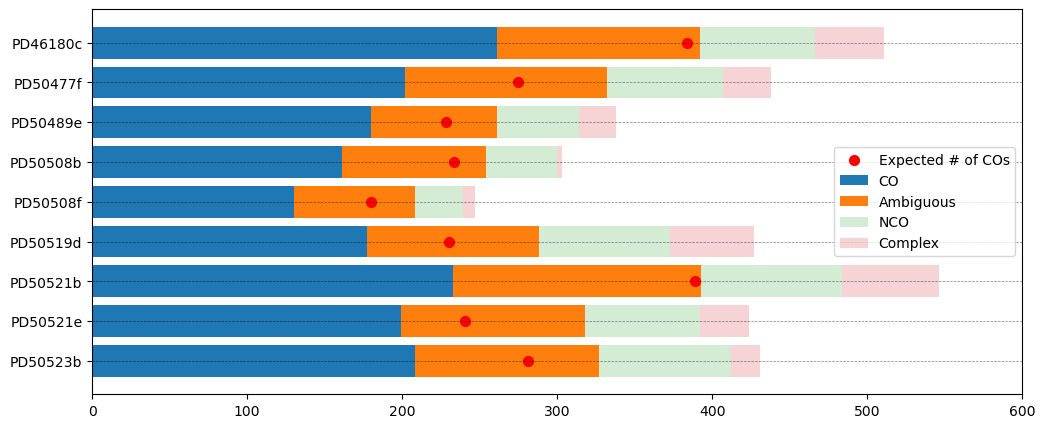

In [182]:
fig, ax = plt.subplots(figsize=(12, 5))
bottom = np.zeros(len(observed_vs_expected_df))

ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["CO"], label="CO")

bottom += observed_vs_expected_df["CO"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["ambiguous"], label="Ambiguous")

bottom += observed_vs_expected_df["ambiguous"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["GC"], label="NCO", alpha=0.2)

bottom += observed_vs_expected_df["GC"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["CNCO"], label="Complex", alpha=0.2)

for i in range(len(observed_vs_expected_df)):
    ax.axhline(i, lw=0.5, color="black", ls="--", alpha=0.5)
    ax.scatter(observed_vs_expected_df["expected_detected_CO"][i], i, color="red", s=50, label=("Expected # of COs" if i == 0 else None))

ax.legend()

ax.set_yticks(ticks=np.arange(len(observed_vs_expected_df)), labels=observed_vs_expected_df["sample_id"]);

ax.invert_yaxis()
ax.set_xlim(0,600);

In [183]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(very_trusty_cls_df
        #.filter(pl.col("sample_id") == "PD50521b")
        #.filter(pl.col("chrom") == "chr1_RagTag")
        .filter(pl.col("class") == "GC")
        .filter(
            (pl.col("idx_transitions").list.get(-1) - pl.col("idx_transitions").list.get(0)) == 6
        )
        #.filter(pl.col("total_clipping") <= 10)
        #.filter(pl.col("total_mismatches") >= 100)
        #.select(["read_name", "class", "total_mismatches"])
    )

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom,sample_id
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,str
"""m64016e_220903_004635/152243004/ccs""",22481,2,"[0, 6]","[794, 3845, … 20768]","""GC""",0,11,10,5,0,0,12,13,60,60,true,true,false,"""chr14_RagTag""","""PD50523b"""
"""m64016e_220816_095555/85328658/ccs""",19202,2,"[1, 7]","[3105, 6980, … 18272]","""GC""",0,3,3,5,0,0,12,13,60,60,false,false,false,"""chr13_RagTag""","""PD50521e"""


# Crossovers per and along the chromosomes

## Per chromosome

In [184]:
c2n = {(x,y.replace("_RagTag", "")):z for x,y,z in (very_trusty_cls_df
    .group_by("class", "chrom")
    .len()
    .iter_rows()
)}


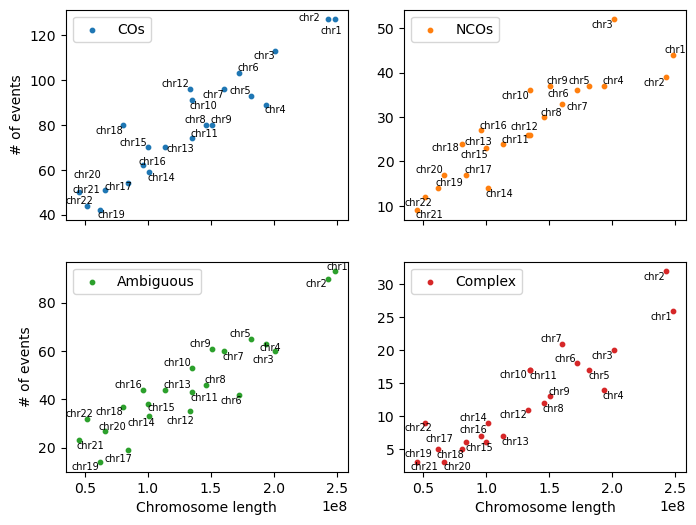

In [185]:
fig, axs = plt.subplots(2, 2, figsize=(8,6), sharex=True)


for class_name, class_label, ax, color in [
    ["CO", "COs", axs[0,0], "C0"],
    ["GC", "NCOs", axs[0,1], "C1"],
    ["ambiguous", "Ambiguous", axs[1,0], "C2"],
    ["CNCO", "Complex", axs[1,1], "C3"],
]:
    xs = [liftover.T2T_chromosome_sizes_in_bp[chrom] for chrom in aut_chrom_names]
    ys = [c2n[class_name, chrom] for chrom in aut_chrom_names]
    
    ax.scatter(
        x = xs,
        y = ys,
        label = class_label,
        s = 10,
        c = color,
    )
    
    texts = [ax.text(xs[i], ys[i], aut_chrom_names[i], ha='center', va='center', fontdict={"size": 7}) for i in range(len(xs))]

    if class_name in ["ambiguous", "CNCO"]:
        ax.set_xlabel("Chromosome length");
    if class_name in ["CO", "ambiguous"]:
        ax.set_ylabel("# of events");
    ax.legend();
    adjust_text(texts, ax=ax)

## Where are they along the chromosome?

In [278]:
all_poses_df = (filtered_annotated_candidates_T2T_df_expanded
    .join(
        very_trusty_cls_df.select("read_name"), 
        on="read_name",
    )
    .select(
        "read_name",
        "sample_id",
        "chrom",
        "class",
        "start_pos_0based",
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("snp_before"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0) + 1).alias("snp_after"),
    )
    .with_columns(
        (pl.col("start_pos_0based") + (pl.col("snp_after") - pl.col("snp_before"))//2).alias("pos_average"),
    )
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    )
)

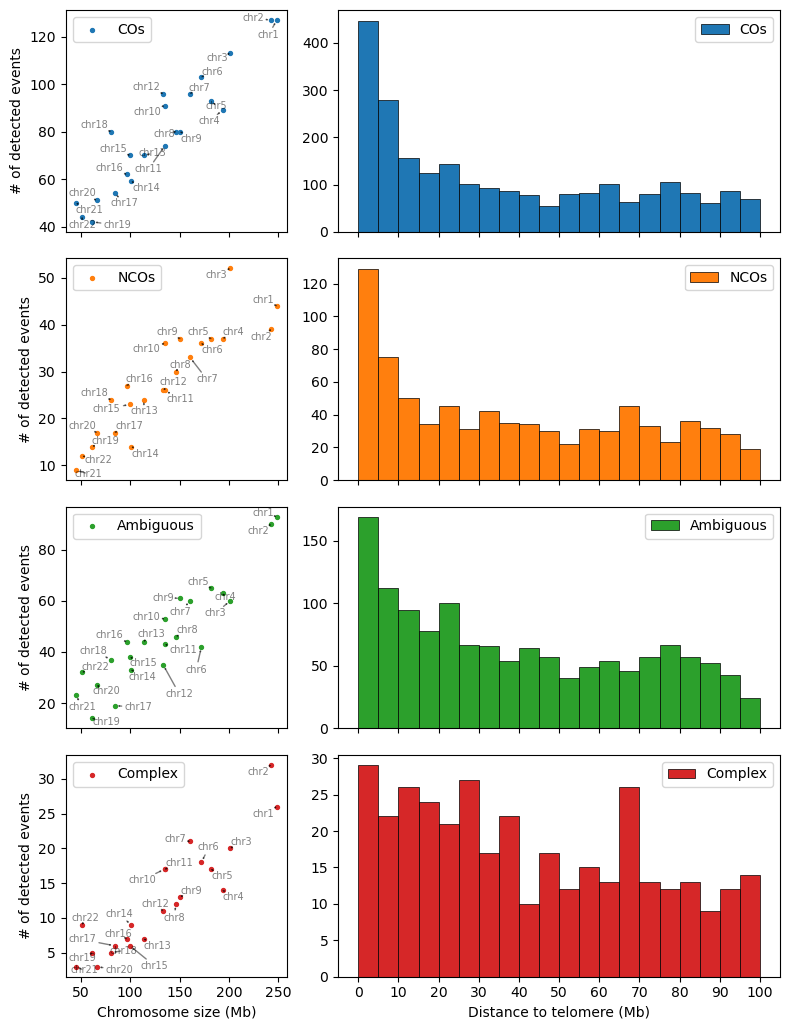

In [279]:
fig, axs = plt.subplots(4, 2, figsize=(10*0.8, 13*0.8), width_ratios=[1,2], sharex="col")

for row, class_name, class_label, color in [
    [0, "CO", "COs", "C0"],
    [1, "GC", "NCOs", "C1"],
    [2, "ambiguous", "Ambiguous", "C2"],
    [3, "CNCO", "Complex", "C3"],
]:

    # Chrom length vs. number of events
    ax = axs[row, 0]
    
    xs = [liftover.T2T_chromosome_sizes_in_bp[chrom] for chrom in aut_chrom_names]
    ys = [c2n[class_name, chrom] for chrom in aut_chrom_names]
    
    ax.scatter(
        x = xs,
        y = ys,
        label = class_label,
        s = 8,
        c = color,
    )
    
    texts = [ax.text(xs[i], ys[i], aut_chrom_names[i], ha='center', va='center', fontdict={"size": 7}, alpha=0.5) for i in range(len(xs))]

    ax.set_ylabel("# of detected events");
    ax.legend();
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', alpha=0.5), min_arrow_len=0, ax=ax)
    
    # Start of telomere
    ax = axs[row, 1]
    
    bins = np.arange(0, 1e8+5e6, 5e6)
    counts = np.histogram(
        pl.concat([
            all_poses_df.filter(pl.col("class") == class_name).select(pl.col("pos_average").alias("dist")),
            all_poses_df.filter(pl.col("class") == class_name).select((pl.col("chrom_length") - pl.col("pos_average")).alias("dist")),
        ]),
        bins = bins,
    )[0]

    xs = (bins[1:]+bins[:-1])/2
    ax.bar(
        x = xs,
        height = counts,
        width = (bins[1]-bins[0]), #*0.8,
#        s = 24,
        label = class_label,
        color = color,
        edgecolor = "black",
        linewidth = 0.5,
    );
    
    ax.legend()
    
axs[3,0].set_xticks(
    np.arange(0.5, 3, 0.5) * 1e8,
    labels = [f"{int(x*100)}" for x in np.arange(0.5, 3, 0.5)],
#    rotation=45,
)
axs[3,0].set_xlabel("Chromosome size (Mb)");

axs[3,1].set_xticks(
    np.arange(0, 1e8+1e7, 1e7),
    labels = [f"{int(x/1e6)}" for x in np.arange(0, 1e8+1e7, 1e7)],
#    rotation=45,    
)

axs[3,1].set_xlabel("Distance to telomere (Mb)");

plt.tight_layout()


## Do events follow the recombination map?

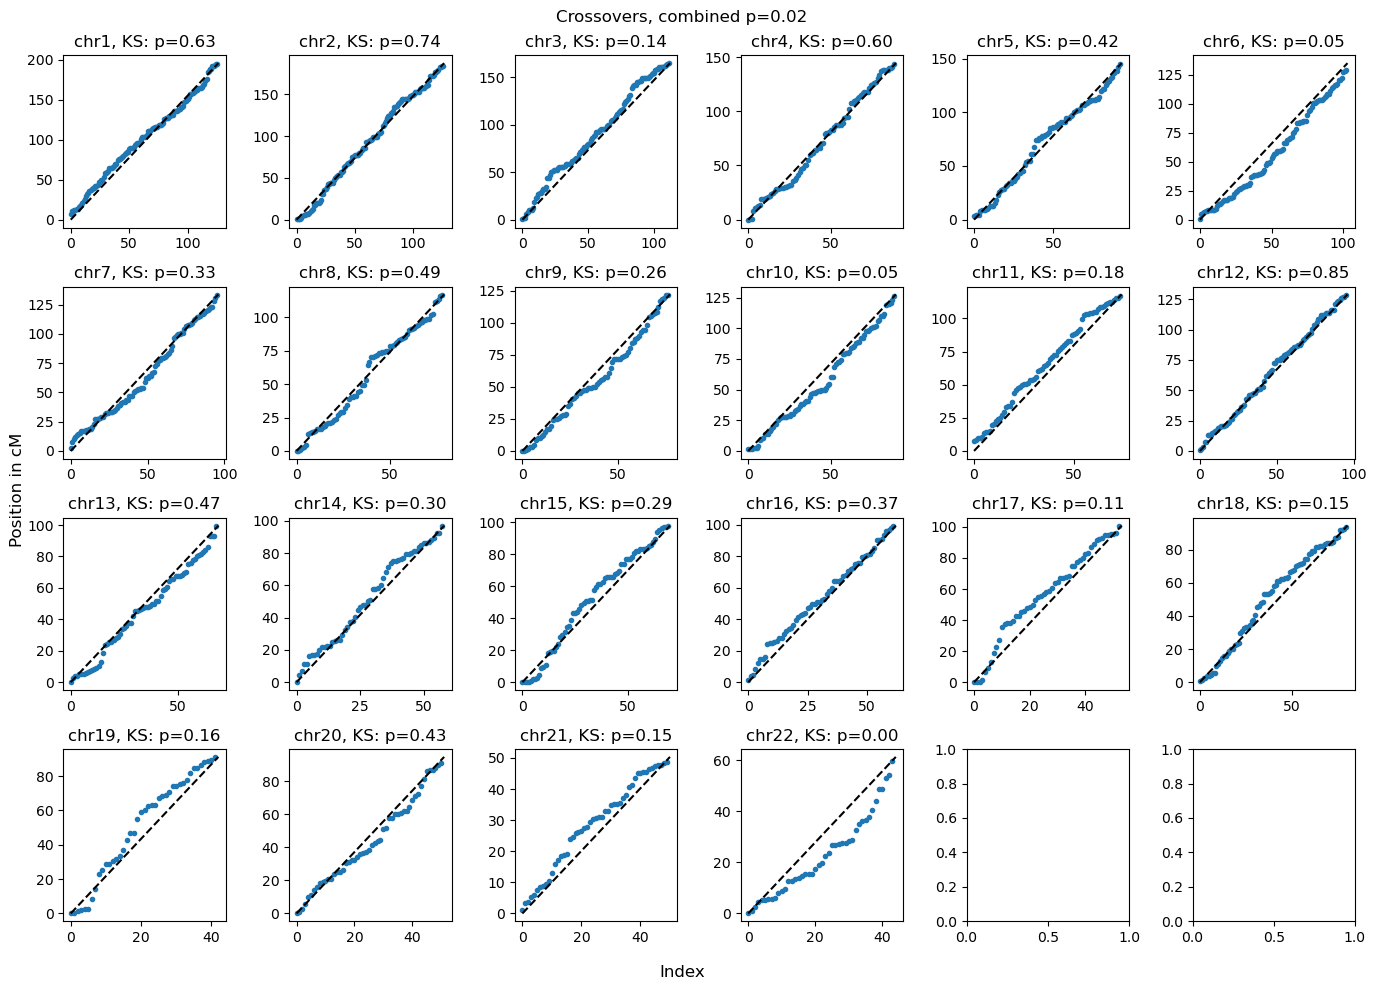

In [280]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "CO") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

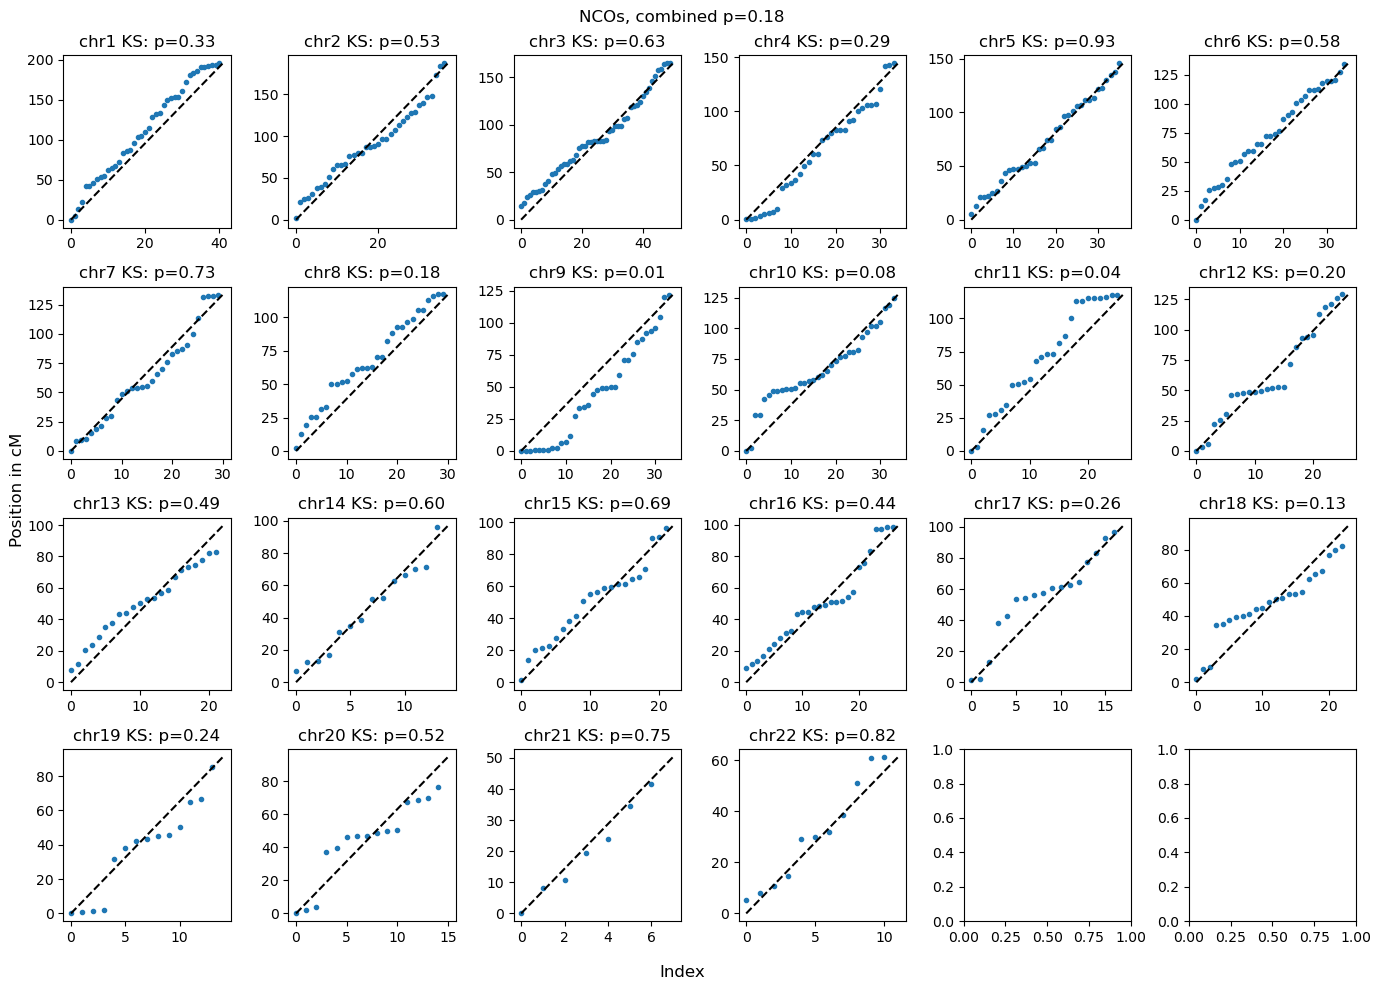

In [281]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "GC") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom} KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"NCOs, combined p={combined:1.2f}");
    
plt.tight_layout()

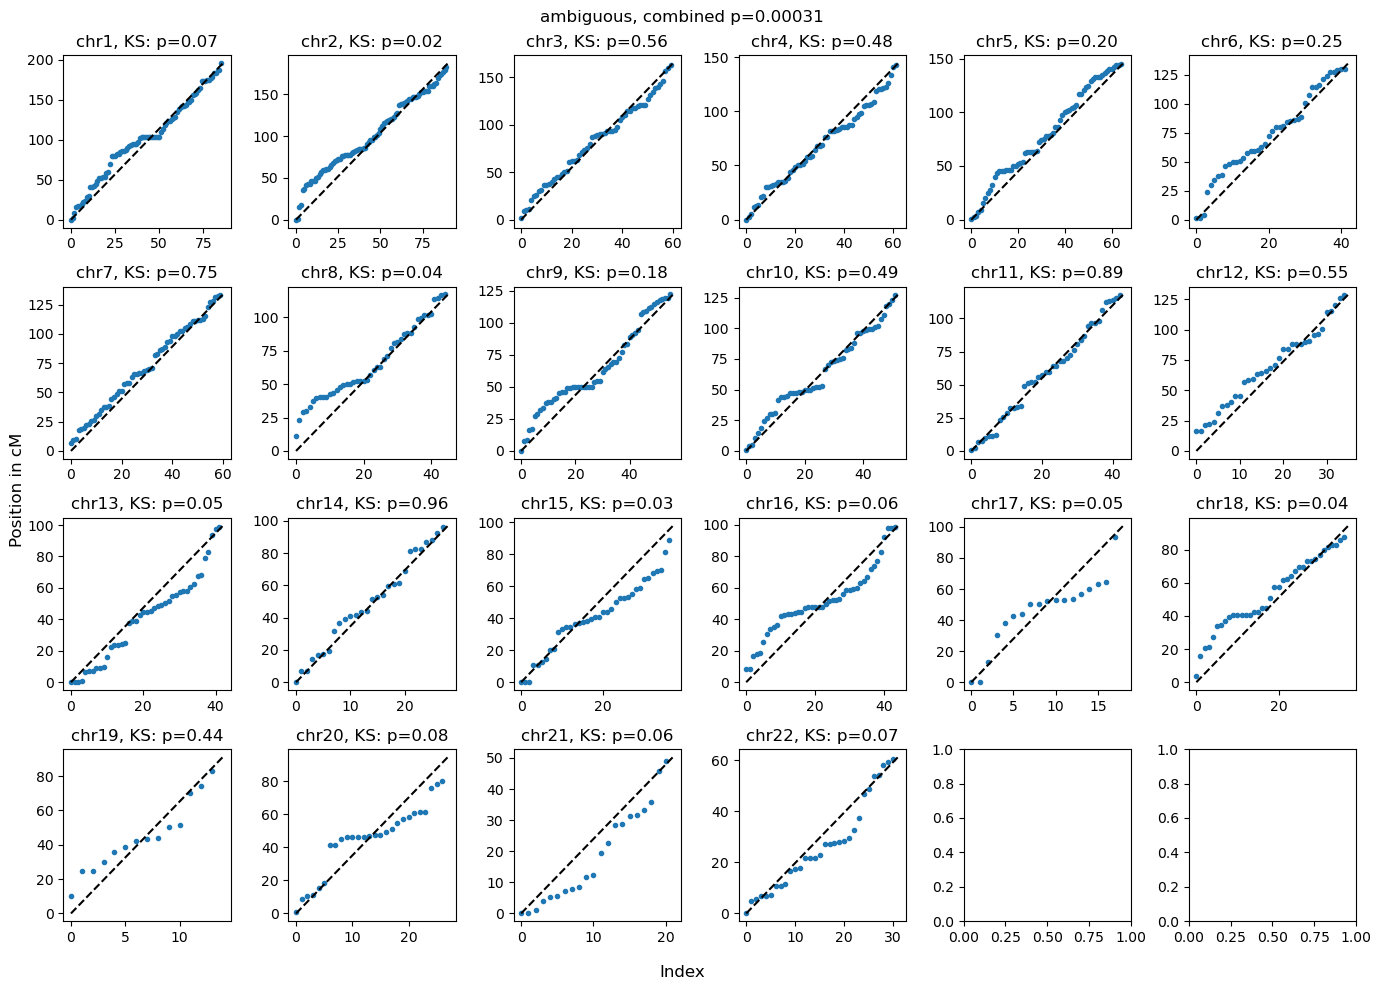

In [190]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "ambiguous") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"ambiguous, combined p={combined:1.5f}");
    
plt.tight_layout()

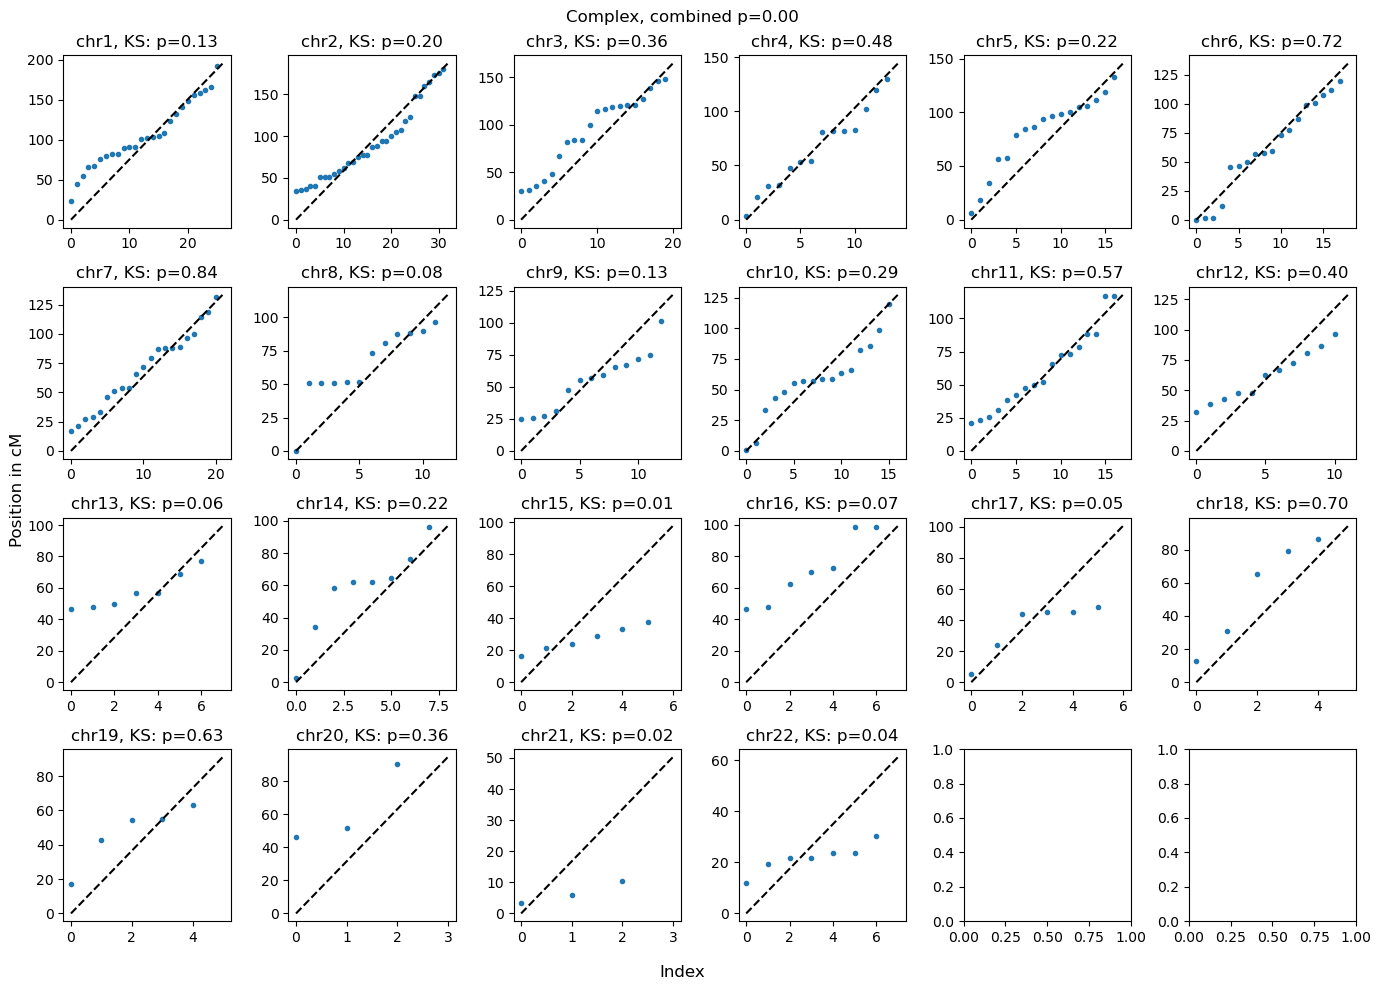

In [191]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "CNCO") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Complex, combined p={combined:1.2f}");
    
plt.tight_layout()

### Per sample?

In [192]:
sorted(sample_ids)

['PD46180c',
 'PD50477f',
 'PD50489e',
 'PD50508b',
 'PD50508f',
 'PD50519d',
 'PD50521b',
 'PD50521e',
 'PD50523b']

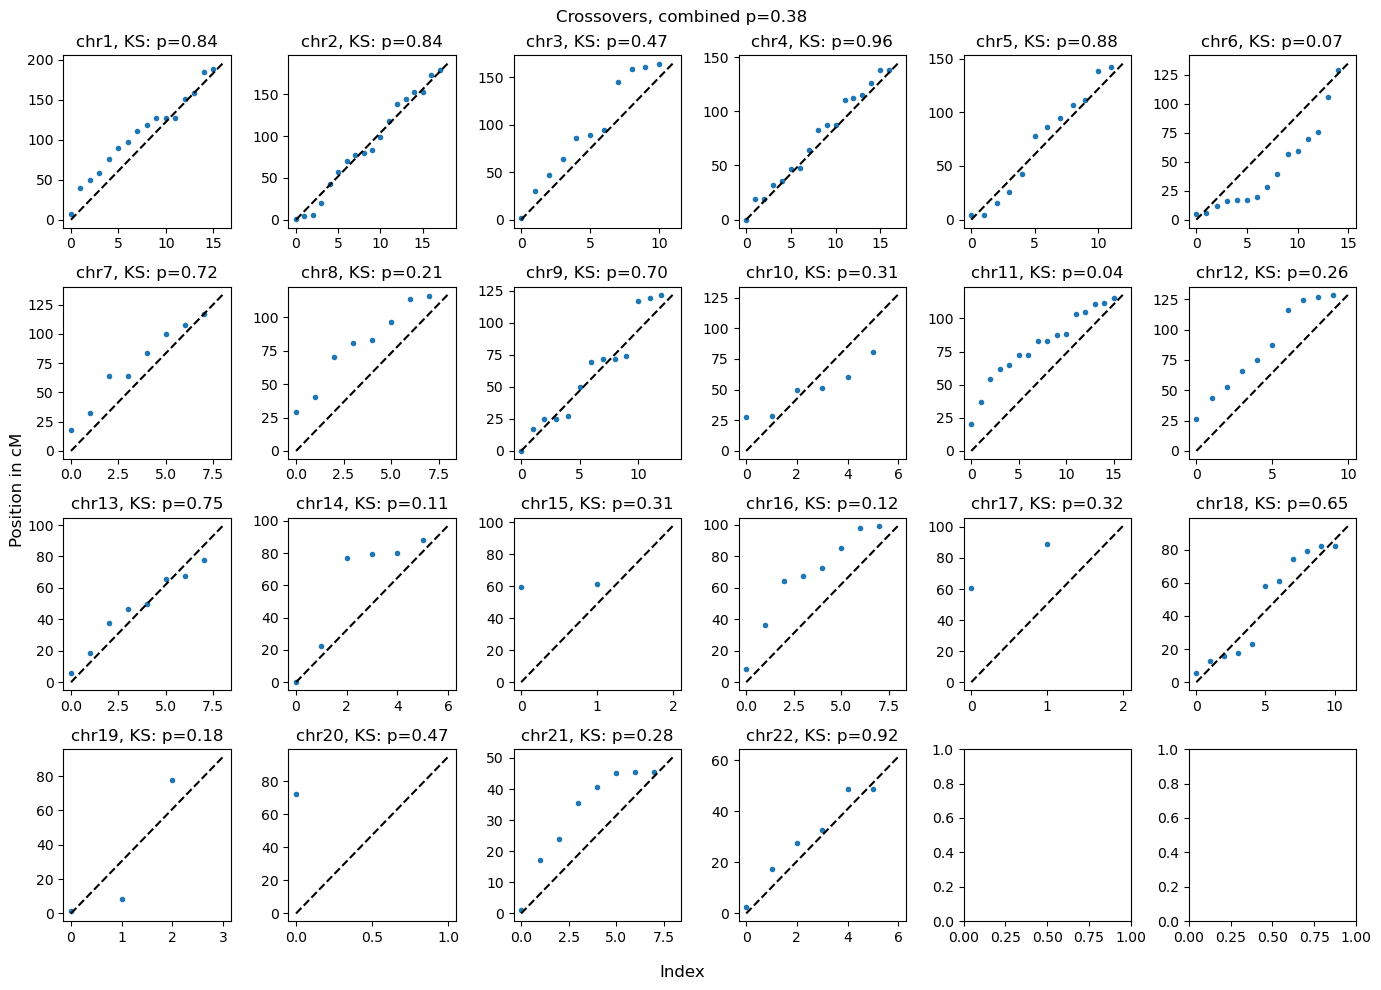

In [193]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

sample_id = "PD50523b"

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter(pl.col("sample_id") == sample_id)
        .filter((pl.col("class") == "CO") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

## Check differences in spatial distribution between classes

In [282]:
cls_maps = {}
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    cls_maps[cls] = {}
    for chrom in aut_chrom_names:
        cls_maps[cls][chrom] = {}
        
        df = (filtered_annotated_candidates_df_expanded
            .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom))
            .drop_nulls()
        )

        midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
        
        cls_maps[cls][chrom] = midpoints

        
rows = []
for cls1, cls2 in itertools.combinations(["CO", "GC", "ambiguous", "CNCO"], 2):
    for chrom in aut_chrom_names:
        x,y = cls_maps[cls1][chrom], cls_maps[cls2][chrom]
        if len(x) and len(y):
            pvalue = scipy.stats.ks_2samp(x,y).pvalue
        else:
            pvalue = None
        rows.append([cls1, cls2, chrom, pvalue])
        
cross_classes_df = pl.DataFrame(rows, schema=["class1", "class2", "chrom", "pvalue"])

In [283]:
cross_classes_df.sort("pvalue")

class1,class2,chrom,pvalue
str,str,str,f64
"""CO""","""CNCO""","""chr15""",0.006224
"""GC""","""CNCO""","""chr15""",0.013569
"""CO""","""ambiguous""","""chr15""",0.013807
"""GC""","""CNCO""","""chr17""",0.014146
"""CO""","""ambiguous""","""chr8""",0.014316
…,…,…,…
"""GC""","""CNCO""","""chr4""",0.908889
"""GC""","""ambiguous""","""chr21""",0.910611
"""GC""","""ambiguous""","""chr20""",0.918163


### Combine p-value across chroms

In [284]:
def fishers_method(df):
    k = len(df)
    test_statistic = -2 * np.log(df["pvalue"]).sum()
    pvalue = scipy.stats.chi2(2*k).cdf(test_statistic)
    return pl.DataFrame({
        "class1": df["class1"][0],
        "class2": df["class2"][0],
        "pvalue": pvalue
    })
    
(cross_classes_df
    .group_by("class1", "class2")
    .map_groups(fishers_method)
    .sort("pvalue")
)

class1,class2,pvalue
str,str,f64
"""GC""","""ambiguous""",0.332994
"""ambiguous""","""CNCO""",0.67972
"""GC""","""CNCO""",0.81574
"""CO""","""GC""",0.922962
"""CO""","""CNCO""",0.9841
"""CO""","""ambiguous""",0.998988


## Are there changes in the event maps between individuals?

In [285]:
rows = []

for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    co_maps = {}
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls()
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    for chrom in aut_chrom_names:
        for id1, id2 in itertools.combinations(sample_ids, 2):
            x,y = co_maps[chrom][id1], co_maps[chrom][id2]
            if len(x) and len(y):
                pvalue = scipy.stats.ks_2samp(x,y).pvalue
            else:
                pvalue = None
            rows.append([cls, chrom, id1, id2, pvalue])

cross_samples_df = pl.DataFrame(rows, schema=["class", "chrom", "sample_id1", "sample_id2", "pvalue"]).drop_nulls()

/tmp/ipykernel_38225/4061390000.py:20: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  pvalue = scipy.stats.ks_2samp(x,y).pvalue


In [286]:
cross_samples_df.sort("pvalue")

class,chrom,sample_id1,sample_id2,pvalue
str,str,str,str,f64
"""ambiguous""","""chr12""","""PD50521b""","""PD50489e""",0.002525
"""GC""","""chr3""","""PD50508b""","""PD50489e""",0.004329
"""CO""","""chr9""","""PD46180c""","""PD50489e""",0.013986
"""CO""","""chr2""","""PD50519d""","""PD50521b""",0.014142
"""ambiguous""","""chr13""","""PD50523b""","""PD46180c""",0.015152
…,…,…,…,…
"""CNCO""","""chr22""","""PD50477f""","""PD46180c""",1.0
"""CNCO""","""chr22""","""PD50477f""","""PD50521e""",1.0
"""CNCO""","""chr22""","""PD50519d""","""PD50521b""",1.0


### Combine across chromosomes


In [287]:
def fishers_method(df):
    # k = len(df)
    # test_statistic = -2 * np.log(df["pvalue"]).sum()
    # pvalue = scipy.stats.chi2(2*k).cdf(test_statistic)
    pvalue = scipy.stats.combine_pvalues(df["pvalue"]).pvalue
    return pl.DataFrame({
        "class": df["class"][0],
        "sample_id1": df["sample_id1"][0],
        "sample_id2": df["sample_id2"][0],
        "pvalue": pvalue,
    })
    
cross_samples_agg_df = (cross_samples_df
    .group_by("class", "sample_id1", "sample_id2")
    .map_groups(fishers_method)
    .sort("pvalue")
)

In [288]:
def pvalue_list_to_matrix(df, sample_ids):
    A = np.zeros((len(sample_ids), len(sample_ids)))

    for row in df.iter_rows(named=True):
        i = sample_ids.index(row["sample_id1"])
        j = sample_ids.index(row["sample_id2"])
        A[i,j] = row["corrected_pvalue"]
        
    A += A.T
    outdf = pd.DataFrame(A, index=sample_ids, columns=sample_ids)
    return outdf
                 
                 

In [289]:
df = cross_samples_agg_df.filter(pl.col("class") == "CO")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CO""","""PD50519d""","""PD50521b""",0.242112
"""CO""","""PD50508b""","""PD50489e""",0.52666
"""CO""","""PD50477f""","""PD50521b""",0.549133
"""CO""","""PD50477f""","""PD46180c""",0.579014
"""CO""","""PD50477f""","""PD50508b""",0.602268
…,…,…,…
"""CO""","""PD50521b""","""PD50521e""",0.993215
"""CO""","""PD50519d""","""PD50508f""",0.995881
"""CO""","""PD50477f""","""PD50489e""",0.996148


In [290]:
df = cross_samples_agg_df.filter(pl.col("class") == "GC")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""GC""","""PD50519d""","""PD50508b""",0.442244
"""GC""","""PD50521b""","""PD50489e""",0.603738
"""GC""","""PD50519d""","""PD50521b""",0.751693
"""GC""","""PD50508b""","""PD50489e""",0.75232
"""GC""","""PD50521b""","""PD46180c""",0.766554
…,…,…,…
"""GC""","""PD50477f""","""PD50508b""",0.998587
"""GC""","""PD46180c""","""PD50489e""",0.998674
"""GC""","""PD50477f""","""PD50519d""",0.99917


In [291]:
df = cross_samples_agg_df.filter(pl.col("class") == "ambiguous")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""ambiguous""","""PD50477f""","""PD46180c""",0.287912
"""ambiguous""","""PD50523b""","""PD46180c""",0.406102
"""ambiguous""","""PD50477f""","""PD50523b""",0.555844
"""ambiguous""","""PD50523b""","""PD50521b""",0.606872
"""ambiguous""","""PD50521b""","""PD50489e""",0.611871
…,…,…,…
"""ambiguous""","""PD50521b""","""PD50521e""",0.9991
"""ambiguous""","""PD50508b""","""PD50489e""",0.999418
"""ambiguous""","""PD50508f""","""PD50508b""",0.999749


In [292]:
df = cross_samples_agg_df.filter(pl.col("class") == "CNCO")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CNCO""","""PD50519d""","""PD50508b""",0.699537
"""CNCO""","""PD50508f""","""PD46180c""",0.791225
"""CNCO""","""PD50477f""","""PD50508b""",0.8
"""CNCO""","""PD50519d""","""PD50508f""",0.810405
"""CNCO""","""PD50521b""","""PD50489e""",0.837434
…,…,…,…
"""CNCO""","""PD50477f""","""PD50523b""",1.0
"""CNCO""","""PD50523b""","""PD50508b""",1.0
"""CNCO""","""PD50521b""","""PD50508b""",1.0


### Try again, with permutation testing

In [293]:
import warnings

n_perms = 1000

def runme(cls, co_maps, chrom, sample_id1, sample_id2):
    pairs = [(co_maps[chrom][sample_id1], co_maps[chrom][sample_id2])]
    with warnings.catch_warnings(action="ignore"):
        pvalue = inference.permutation_testing(pairs, n_perms=n_perms)
    return [cls, chrom, sample_id1, sample_id2, pvalue]

rows = []
all_co_maps = {}
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    print(cls)
    co_maps = {}
    all_co_maps[cls] = co_maps
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    cls_rows = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(cls, co_maps, chrom, sample_id1, sample_id2) \
            for chrom in aut_chrom_names \
            for sample_id1, sample_id2 in itertools.combinations(sample_ids, 2)
    )
    
    rows.extend(cls_rows)
        

cross_samples_perm_df = pl.DataFrame(rows, schema=["class", "chrom", "sample_id1", "sample_id2", "pvalue"])

CO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GC


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.6s
[Paralle

ambiguous


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.9s
[Paralle

CNCO


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1241006851196289s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1837206946377385s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17877794040172915s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11121702194213867s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10336

In [295]:
with pl.Config(tbl_rows=20, fmt_str_lengths=100):
    display(cross_samples_perm_df
        .filter(pl.col("class") == "GC")
        .sort("pvalue")
    )

class,chrom,sample_id1,sample_id2,pvalue
str,str,str,str,f64
"""GC""","""chr3""","""PD50508b""","""PD50489e""",0.002
"""GC""","""chr3""","""PD50521b""","""PD50489e""",0.009
"""GC""","""chr3""","""PD50519d""","""PD50508b""",0.022
"""GC""","""chr15""","""PD50521b""","""PD46180c""",0.022
"""GC""","""chr3""","""PD50477f""","""PD50508b""",0.026
"""GC""","""chr5""","""PD50508b""","""PD50489e""",0.026
"""GC""","""chr18""","""PD50521b""","""PD50521e""",0.026
"""GC""","""chr8""","""PD50519d""","""PD50521b""",0.03
"""GC""","""chr3""","""PD46180c""","""PD50489e""",0.034


In [301]:
1/792

0.0012626262626262627

In [297]:
x = all_co_maps["GC"]["chr3"]['PD50508b']
y = all_co_maps["GC"]["chr3"]["PD50489e"]

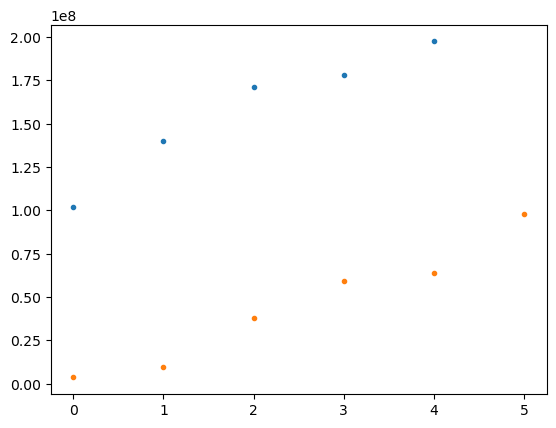

In [298]:
plt.plot(x, '.')
plt.plot(y, '.')

#### Compare with subsampled COs

In [299]:
import warnings

n_perms = 1000

def runme(cls, co_maps, chrom, sample_id1, sample_id2):
    pairs = [(co_maps[chrom][sample_id1], co_maps[chrom][sample_id2])]
    with warnings.catch_warnings(action="ignore"):
        pvalue = inference.permutation_testing(pairs, n_perms=n_perms)
    return [cls, chrom, sample_id1, sample_id2, pvalue]

rows = []
subsampled_all_co_maps = {}
for cls in ["CO"]:
    print(cls)
    co_maps = {}
    subsampled_all_co_maps[cls] = co_maps
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
                .sample(fraction=0.2)
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    cls_rows = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(cls, co_maps, chrom, sample_id1, sample_id2) \
            for chrom in aut_chrom_names \
            for sample_id1, sample_id2 in itertools.combinations(sample_ids, 2)
    )
    
    rows.extend(cls_rows)
        

subsampled_cross_samples_perm_df = pl.DataFrame(rows, schema=["class", "chrom", "sample_id1", "sample_id2", "pvalue"])

CO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18115667908075844s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1637115478515625s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06922316551208496s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1803579330444336s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Batch computation too 

In [211]:
subsampled_cross_samples_perm_df.sort("pvalue")

class,chrom,sample_id1,sample_id2,pvalue
str,str,str,str,f64
"""CO""","""chr1""","""PD50523b""","""PD50489e""",0.098
"""CO""","""chr7""","""PD50521b""","""PD46180c""",0.098
"""CO""","""chr1""","""PD50523b""","""PD50521e""",0.199
"""CO""","""chr11""","""PD50523b""","""PD46180c""",0.234
"""CO""","""chr1""","""PD46180c""","""PD50489e""",0.31
…,…,…,…,…
"""CO""","""chr22""","""PD50508b""","""PD50521e""",1.0
"""CO""","""chr22""","""PD50508b""","""PD50489e""",1.0
"""CO""","""chr22""","""PD46180c""","""PD50521e""",1.0


In [212]:
import warnings

n_perms = 5000

read_length_cutoff = 0

def runme(cls, co_maps, sample_id1, sample_id2):
    pairs = [(co_maps[chrom][sample_id1], co_maps[chrom][sample_id2]) for chrom in aut_chrom_names]
    with warnings.catch_warnings(action="ignore"):
        pvalue = inference.permutation_testing(pairs, n_perms=n_perms)
    return [cls, sample_id1, sample_id2, pvalue]

rows = []
per_class_maps = {}
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    print(cls)
    co_maps = {}
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter(pl.col("read_length") >= read_length_cutoff)
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    cls_rows = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(cls, co_maps, sample_id1, sample_id2) \
            for sample_id1, sample_id2 in itertools.combinations(sample_ids, 2)
    )
    
    per_class_maps[cls] = co_maps
    
    rows.extend(cls_rows)
        

cross_samples_perm_agg_df = pl.DataFrame(rows, schema=["class", "sample_id1", "sample_id2", "pvalue"])

CO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  5.2min remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.4min finished


GC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  1.9min remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.0min finished


ambiguous


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  3.8min remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.0min finished


CNCO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.023174762725830078s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (7.185276985168457s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:   17.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   19.2s finished


In [213]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(cross_samples_perm_agg_df
        .filter(pl.col("class") == "GC")
        .sort("pvalue")
    )

class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""GC""","""PD50508b""","""PD50489e""",0.0008
"""GC""","""PD50508f""","""PD50508b""",0.008
"""GC""","""PD50521b""","""PD50489e""",0.0198
"""GC""","""PD50477f""","""PD50489e""",0.0576
"""GC""","""PD50519d""","""PD50523b""",0.0838
"""GC""","""PD50477f""","""PD50508b""",0.087
"""GC""","""PD50519d""","""PD50508b""",0.1188
"""GC""","""PD50508b""","""PD46180c""",0.1458
"""GC""","""PD50508f""","""PD50521e""",0.2114


In [214]:
combined_ps = []
for focal_sample_id in sample_ids:
    ps = (cross_samples_perm_agg_df
        .filter(pl.col("class") == "GC")
        .filter((pl.col("sample_id1") == focal_sample_id) | (pl.col("sample_id2") == focal_sample_id))
        #.filter((pl.col("sample_id1") != "PD50489e") & (pl.col("sample_id2") != "PD50489e"))
    )["pvalue"]

    cp = scipy.stats.combine_pvalues(ps)
    print(focal_sample_id, cp)
    combined_ps.append(cp.pvalue)

PD50477f SignificanceResult(statistic=18.64298338176794, pvalue=0.28761074990075775)
PD50519d SignificanceResult(statistic=21.41056693781492, pvalue=0.16326324545256568)
PD50508f SignificanceResult(statistic=18.594196851244998, pvalue=0.290267075386956)
PD50523b SignificanceResult(statistic=10.699891213892325, pvalue=0.8276196671692795)
PD50521b SignificanceResult(statistic=19.944913151866885, pvalue=0.222711993739415)
PD50508b SignificanceResult(statistic=39.08075906846824, pvalue=0.001058801243513554)
PD46180c SignificanceResult(statistic=14.204745506815652, pvalue=0.5834637885287188)
PD50521e SignificanceResult(statistic=11.738531342806025, pvalue=0.7617742812964569)
PD50489e SignificanceResult(statistic=33.825043253169426, pvalue=0.0057355813551489936)


In [215]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(cross_samples_perm_agg_df
        .filter(pl.col("class") == "CO")
        .sort("pvalue")
    )

class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CO""","""PD50519d""","""PD50521b""",0.1976
"""CO""","""PD50508f""","""PD50521e""",0.2758
"""CO""","""PD50477f""","""PD50519d""",0.308
"""CO""","""PD50477f""","""PD50521b""",0.3092
"""CO""","""PD50508f""","""PD50489e""",0.3776
"""CO""","""PD50523b""","""PD50521b""",0.4046
"""CO""","""PD50477f""","""PD50508b""",0.4124
"""CO""","""PD50521b""","""PD50489e""",0.4208
"""CO""","""PD50508f""","""PD50508b""",0.4328


### Try again, now combining also groups of samples + perm testing

In [216]:
young_samples = [k for k,v in sample_id_to_age.items() if v < 40]
old_samples = [k for k,v in sample_id_to_age.items() if v >= 40]

In [217]:
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    pairs_per_age = [(
        np.concatenate([per_class_maps[cls][chrom][k] for k in young_samples]), 
        np.concatenate([per_class_maps[cls][chrom][k] for k in old_samples])
     ) for chrom in aut_chrom_names]
    with warnings.catch_warnings(action="ignore"):
        print("Chroms: ", end='')
        for pair, chrom in zip(pairs_per_age, aut_chrom_names):
            print(inference.permutation_testing([pair], n_perms=1000), end=' ')
        print()
        print(cls, inference.permutation_testing(pairs_per_age, n_perms=1000))

Chroms: 0.404 0.634 0.861 0.391 0.953 0.859 0.874 0.659 0.477 0.636 0.765 0.641 0.487 0.553 0.056 0.709 0.216 0.75 0.624 0.617 0.604 0.94 
CO 0.991
Chroms: 0.173 0.562 0.435 0.276 0.27 0.546 0.095 0.662 0.671 0.238 0.451 0.953 0.19 0.975 0.894 0.002 0.536 0.111 0.18 0.179 0.242 0.947 
GC 0.152
Chroms: 0.764 0.412 0.064 0.936 0.525 0.85 0.642 0.788 0.886 0.413 0.376 0.148 0.897 0.491 0.399 0.408 0.002 0.665 0.113 0.526 0.606 0.529 
ambiguous 0.502
Chroms: 0.909 0.866 0.217 0.086 0.81 0.3 0.687 0.121 0.001 0.06 0.73 1.0 0.413 0.966 1.0 0.128 1.0 1.0 1.0 1.0 1.0 1.0 
CNCO 0.026


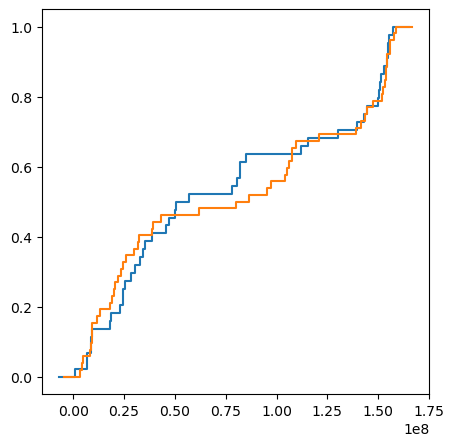

In [218]:
cls = "CO"
pairs_per_age = [(
    np.concatenate([per_class_maps[cls][chrom][k] for k in young_samples]), 
    np.concatenate([per_class_maps[cls][chrom][k] for k in old_samples])
 ) for chrom in aut_chrom_names]

fig, ax = plt.subplots(figsize=(5,5))

scipy.stats.ecdf(pairs_per_age[6][0]).cdf.plot(ax)
scipy.stats.ecdf(pairs_per_age[6][1]).cdf.plot(ax)


### Test one sample vs. all others

In [302]:
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    for focal_sample_id in sample_ids:
        other_samples = [x for x in sample_ids if x != focal_sample_id]
        pairs_per_sample = [(
            np.concatenate([per_class_maps[cls][chrom][focal_sample_id]]), 
            np.concatenate([per_class_maps[cls][chrom][k] for k in other_samples])
         ) for chrom in aut_chrom_names]
        with warnings.catch_warnings(action="ignore"):
            # print("Chroms: ", end='')
            # for pair, chrom in zip(pairs_per_sample, aut_chrom_names):
            #     print(inference.permutation_testing([pair], n_perms=1000), end=' ')
            # print()
            print(cls, focal_sample_id, inference.permutation_testing(pairs_per_sample, n_perms=1000))

CO PD50477f 0.601
CO PD50519d 0.395
CO PD50508f 0.417
CO PD50523b 0.377
CO PD50521b 0.63
CO PD50508b 0.922
CO PD46180c 0.954
CO PD50521e 0.978
CO PD50489e 0.533
GC PD50477f 0.441
GC PD50519d 0.253
GC PD50508f 0.778
GC PD50523b 0.81
GC PD50521b 0.358
GC PD50508b 0.125
GC PD46180c 0.548
GC PD50521e 0.9
GC PD50489e 0.379
ambiguous PD50477f 0.541
ambiguous PD50519d 0.766
ambiguous PD50508f 0.405
ambiguous PD50523b 0.055
ambiguous PD50521b 0.423
ambiguous PD50508b 0.598
ambiguous PD46180c 0.3
ambiguous PD50521e 0.638
ambiguous PD50489e 0.842
CNCO PD50477f 0.164
CNCO PD50519d 0.316
CNCO PD50508f 1.0
CNCO PD50523b 0.393
CNCO PD50521b 0.676
CNCO PD50508b 1.0
CNCO PD46180c 0.098
CNCO PD50521e 0.798
CNCO PD50489e 0.461


### Test one sample vs. all the others, but as different pairs

In [303]:
for cls in ["CO", "GC"]:
    for focal_sample_id in sample_ids:
        other_samples = [x for x in sample_ids if x != focal_sample_id]
        pairs_per_sample = [(
            per_class_maps[cls][chrom][focal_sample_id],
            per_class_maps[cls][chrom][k],
         ) for chrom in aut_chrom_names for k in other_samples]
        with warnings.catch_warnings(action="ignore"):
            # print("Chroms: ", end='')
            # for pair, chrom in zip(pairs_per_sample, aut_chrom_names):
            #     print(inference.permutation_testing([pair], n_perms=1000), end=' ')
            # print()
            print(cls, focal_sample_id, inference.permutation_testing(pairs_per_sample, n_perms=1000))

CO PD50477f 0.931
CO PD50519d 0.716
CO PD50508f 0.621
CO PD50523b 0.948
CO PD50521b 0.733
CO PD50508b 0.97
CO PD46180c 1.0
CO PD50521e 0.994
CO PD50489e 0.969
GC PD50477f 0.235
GC PD50519d 0.107
GC PD50508f 0.483
GC PD50523b 0.839
GC PD50521b 0.179
GC PD50508b 0.005
GC PD46180c 0.55
GC PD50521e 0.634
GC PD50489e 0.026


In [304]:
for cls in ["GC"]:
    for focal_sample_id in ["PD50489e"]:
        other_samples = [x for x in sample_ids if x != focal_sample_id]
        pairs_per_sample = [(
            per_class_maps[cls][chrom][focal_sample_id],
            per_class_maps[cls][chrom][k],
         ) for chrom in aut_chrom_names for k in other_samples]
        with warnings.catch_warnings(action="ignore"):
            # print("Chroms: ", end='')
            # for pair, chrom in zip(pairs_per_sample, aut_chrom_names):
            #     print(inference.permutation_testing([pair], n_perms=1000), end=' ')
            # print()
            print(cls, focal_sample_id, inference.permutation_testing(pairs_per_sample, n_perms=1000)) # I tried with 100000

GC PD50489e 0.026


### Now between classes

In [222]:
cls1 = "CO"
cls2 = "GC"

pairs_per_class = [(
    np.concatenate([per_class_maps[cls1][chrom][k] for k in sample_ids]), 
    np.concatenate([per_class_maps[cls2][chrom][k] for k in sample_ids])
 ) for chrom in aut_chrom_names]
with warnings.catch_warnings(action="ignore"):
    print("Chroms: ", end='')
    for pair, chrom in zip(pairs_per_class, aut_chrom_names):
        print(inference.permutation_testing([pair], n_perms=1000), end=' ')
    print()
    print(cls1, "vs.", cls2, inference.permutation_testing(pairs_per_class, n_perms=1000))

Chroms: 0.246 0.188 0.517 0.273 0.754 0.077 0.459 0.157 0.11 0.049 0.122 0.655 0.399 0.438 0.424 0.62 0.892 0.227 0.11 0.238 0.246 0.192 
CO vs. GC 0.071


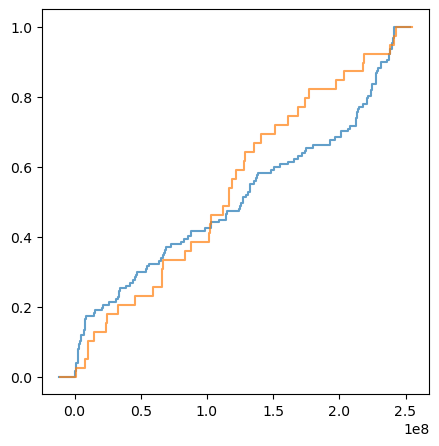

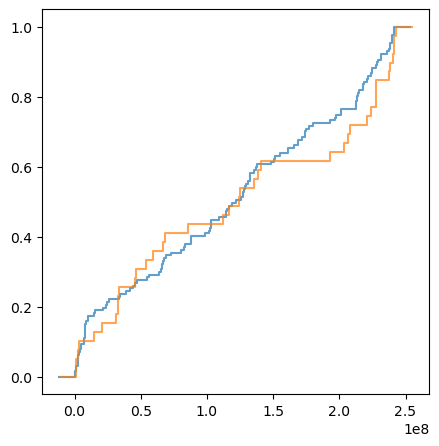

In [223]:

n_chr = 1

x,y = pairs_per_class[n_chr]

fig, ax = plt.subplots(figsize=(5,5))
scipy.stats.ecdf(x).cdf.plot(ax, alpha=0.7)
scipy.stats.ecdf(y).cdf.plot(ax, alpha=0.7)

px, py = np.array_split(np.random.permutation(np.concatenate([x,y])), [len(x)])

fig, ax = plt.subplots(figsize=(5,5))
scipy.stats.ecdf(px).cdf.plot(ax, alpha=0.7)
scipy.stats.ecdf(py).cdf.plot(ax, alpha=0.7)


# GC positions, between individuals

In [224]:
df = (filtered_annotated_candidates_df_expanded
    .filter((pl.col("class") == "GC") & (pl.col("chrom") == "chr3") & (pl.col("sample_id") == "PD50508b"))
    .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
    .with_columns(
        avg_active_pos = (pl.col("active_start_pos") + pl.col("active_end_pos"))//2,
    )
)

In [225]:
df

read_name,frac_fits1_super_conf,start_pos_0based,end_pos_0based,mapq,read_length,start_pos_cM,cM,prob_CO,cM_per_bp_across_read,sample_id,chrom,read_length_right,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom_denovo,active_start_pos,active_end_pos,active_region_length,active_start_pos_cM,active_end_pos_cM,active_cM,cM_per_bp_across_active,avg_active_pos
str,f64,i64,i64,i64,i64,f64,f64,f64,f64,str,str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,i64,i64,i64,f64,f64,f64,f64,i64
"""m64016e_220905…",0.958333,171312015,171328126,60,16092,124.276909,0.059917,0.000599,0.000004,"""PD50508b""","""chr3""",16092,2,"[1, 2]","[1396, 1490, … 15112]","""GC""",0,1,1,4,0,0,14,10,60,60,false,false,false,"""chr3_RagTag""",171313505,171314227,722,124.336514,124.336561,0.000047,6.4742e-8,171313866
"""m64016e_220905…",0.833333,139826277,139838626,60,12350,107.481383,0.057306,0.000573,0.000005,"""PD50508b""","""chr3""",12350,2,"[3, 4]","[749, 6630, … 11306]","""GC""",0,1,1,0,0,0,8,12,60,60,false,false,false,"""chr3_RagTag""",139835692,139835921,229,107.528263,107.538426,0.010163,0.000044,139835806
"""m64016e_220905…",0.083333,178171646,178185974,60,14330,130.370016,0.079432,0.000794,0.000006,"""PD50508b""","""chr3""",14330,2,"[0, 1]","[1620, 2316, … 12423]","""GC""",0,1,1,9,0,0,8,12,60,60,false,false,false,"""chr3_RagTag""",178173266,178174697,1431,130.374296,130.441435,0.067139,0.000047,178173981
"""m64016e_220905…",0.111111,101660764,101679279,60,18493,83.146949,0.048877,0.000489,0.000003,"""PD50508b""","""chr3""",18493,2,"[3, 4]","[1734, 2547, … 15412]","""GC""",0,1,1,37,0,0,15,10,60,60,false,false,false,"""chr3_RagTag""",101670678,101671865,1187,83.186427,83.195001,0.008573,0.000007,101671271
"""m64016e_220905…",0.037037,197374896,197388297,60,13390,164.512779,0.011505,0.000115,8.5920e-7,"""PD50508b""","""chr3""",13390,2,"[31, 32]","[674, 706, … 10588]","""GC""",0,4,4,14,0,0,7,14,60,60,true,true,false,"""chr3_RagTag""",197379956,197380287,331,164.517123,164.517407,0.000284,8.5850e-7,197380121


In [226]:
df["read_name"][2]

'm64016e_220905_200242/72089926/ccs'

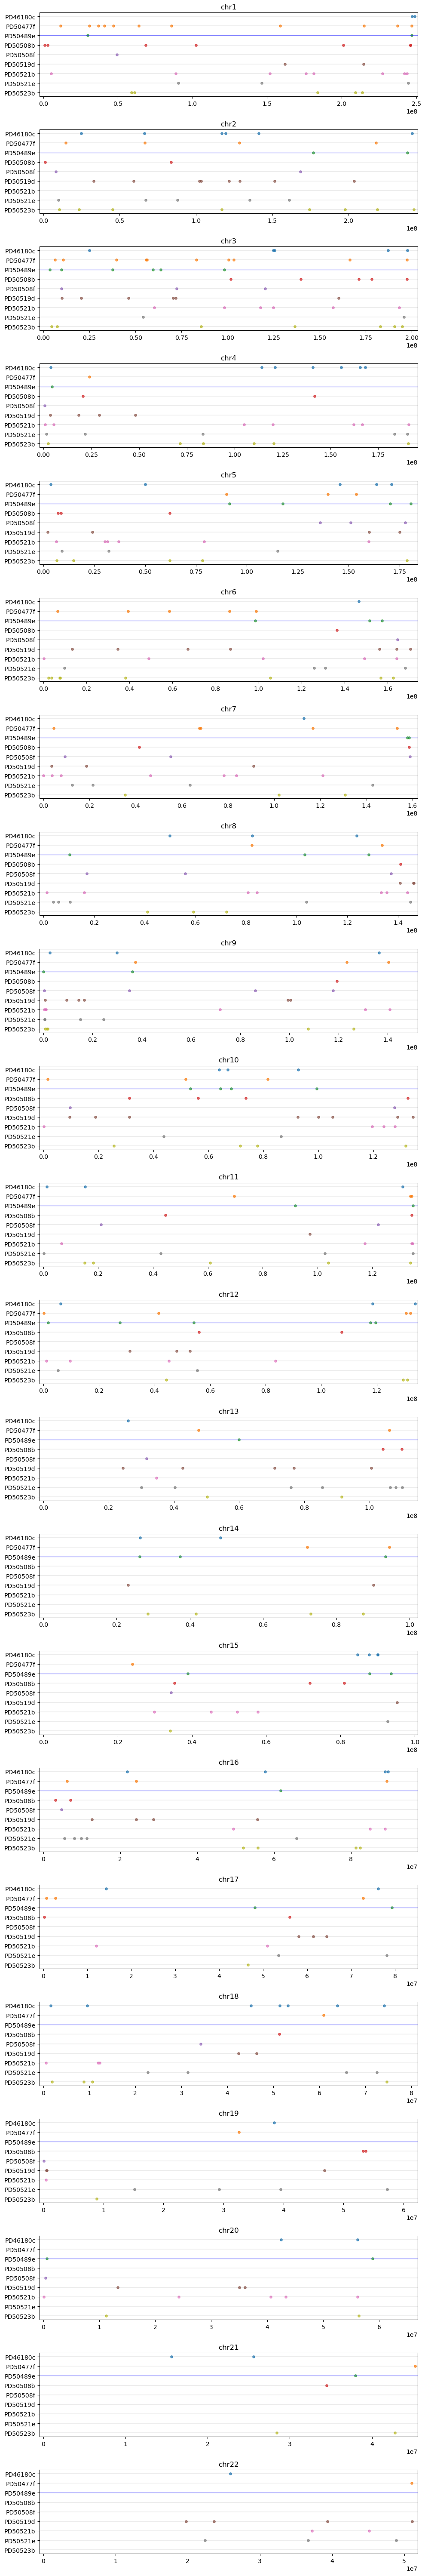

In [300]:
fig, axes = plt.subplots(nrows=len(aut_chrom_names), figsize=(10, 60))

for ax, chrom in zip(axes, aut_chrom_names):
    for i, sample_id in enumerate(sorted(sample_ids)):
        df = (filtered_annotated_candidates_df_expanded
            .filter((pl.col("class") == "GC") & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
            .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            .with_columns(
                avg_active_pos = (pl.col("active_start_pos") + pl.col("active_end_pos"))//2,
            )
        )

        ax.scatter(
            x = df["avg_active_pos"],
            y = [i]*len(df),
            s = 15,
            alpha = 0.7,
        )

        if sample_id == "PD50489e":
            ax.axhline(y=i, color="blue", lw=1, alpha=0.5)
        else:
            ax.axhline(y=i, color="black", lw=0.2, alpha=0.5)

    ax.set_title(chrom)
    ax.set_xlim(liftover.T2T_chromosome_sizes_in_bp[chrom]*-0.01, liftover.T2T_chromosome_sizes_in_bp[chrom]*1.01)
    ax.set_yticks(np.arange(len(sample_ids)), sorted(sample_ids));
    ax.invert_yaxis();
    
plt.tight_layout()

### Does this happen in COs?

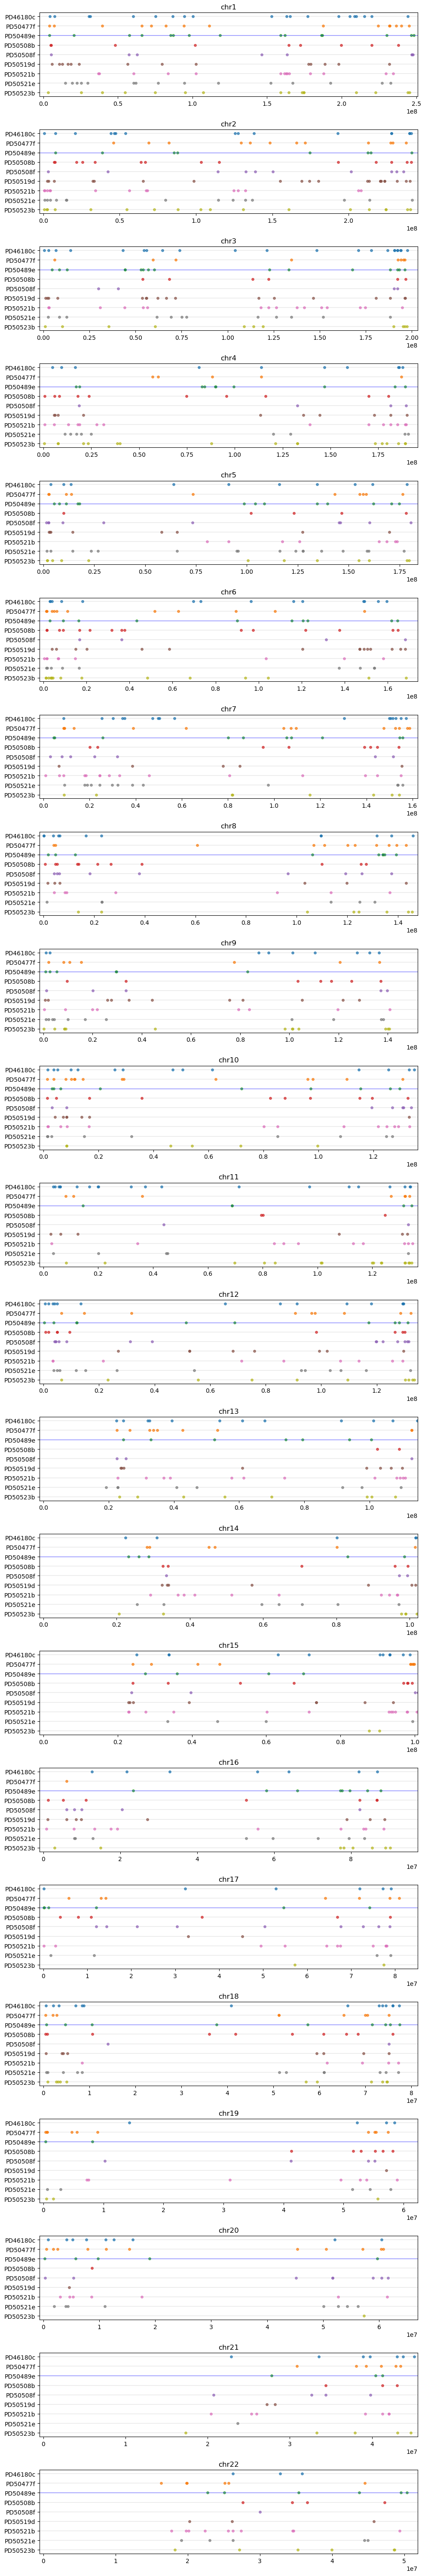

In [228]:
fig, axes = plt.subplots(nrows=len(aut_chrom_names), figsize=(10, 60))

for ax, chrom in zip(axes, aut_chrom_names):
    for i, sample_id in enumerate(sorted(sample_ids)):
        df = (filtered_annotated_candidates_df_expanded
            .filter((pl.col("class") == "CO") & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
            .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            .with_columns(
                avg_active_pos = (pl.col("active_start_pos") + pl.col("active_end_pos"))//2,
            )
        )

        ax.scatter(
            x = df["avg_active_pos"],
            y = [i]*len(df),
            s = 15,
            alpha = 0.7,
        )

        if sample_id == "PD50489e":
            ax.axhline(y=i, color="blue", lw=1, alpha=0.5)
        else:
            ax.axhline(y=i, color="black", lw=0.2, alpha=0.5)

    ax.set_title(chrom)
    ax.set_xlim(liftover.T2T_chromosome_sizes_in_bp[chrom]*-0.01, liftover.T2T_chromosome_sizes_in_bp[chrom]*1.01)
    ax.set_yticks(np.arange(len(sample_ids)), sorted(sample_ids));
    ax.invert_yaxis();
    
plt.tight_layout()

# GC tracts

## Draw them?

In [229]:
gc_patterns = (very_trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(
        first_converted_snp = pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        before_flanking_snp = pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        after_flanking_snp = pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1)+1),
        n_converted_snps = pl.col("idx_transitions").list.get(-1) - pl.col("idx_transitions").list.get(0),
    )
    .with_columns(
        interval_before = pl.col("before_flanking_snp") - pl.col("first_converted_snp"),
        interval_after = pl.col("after_flanking_snp") - pl.col("first_converted_snp"),
        upper_bound_tract_length = pl.col("after_flanking_snp") - pl.col("before_flanking_snp"),
    )
)

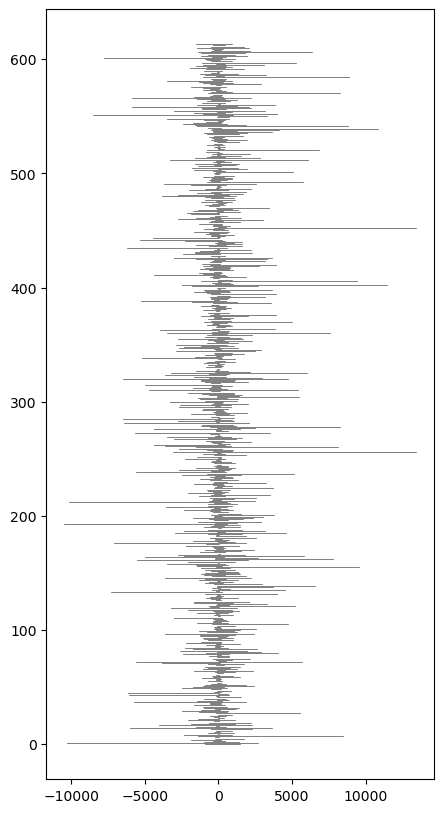

In [230]:
fig, ax = plt.subplots(figsize=(5, 10))

for n_row, row in enumerate(gc_patterns.iter_rows(named=True)):
    ax.plot(
        [row["interval_before"], row["interval_after"]],
        [n_row, n_row],
        color="black",
        alpha=0.7,
        lw=0.5,
    );

## Plot GC tract statistics

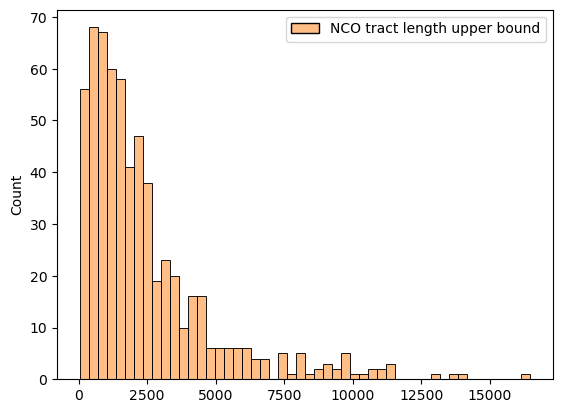

In [231]:
sns.histplot(
    [
        pd.Series(gc_patterns["upper_bound_tract_length"], name="NCO tract length upper bound")
    ],
    bins=50, #np.linspace(0,3000,50),
    #log_scale=True,
    palette=["C1"],    
);
        

In [232]:
print("Mean upper bound:", np.mean(gc_patterns["upper_bound_tract_length"].to_numpy()))
print("Median upper bound:", np.median(gc_patterns["upper_bound_tract_length"].to_numpy()))
print("Min upper bound:", np.min(gc_patterns["upper_bound_tract_length"].to_numpy()))
print("Max upper bound:", np.max(gc_patterns["upper_bound_tract_length"].to_numpy()))

Mean upper bound: 2425.529315960912
Median upper bound: 1664.0
Min upper bound: 39
Max upper bound: 16481


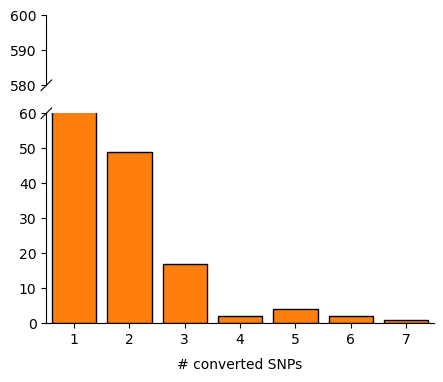

In [233]:
fig = plt.figure(figsize=(5,4))
bax = brokenaxes(xlims=((0.5, 7.5),), ylims=((0, 60), (580, 600)), hspace=0.2)

bax.bar(
    np.arange(1, 10)[:-1],
    np.histogram(gc_patterns["n_converted_snps"], bins=np.arange(1,10))[0],
    align="center",
    color="C1",
    edgecolor='black', 
    linewidth=1,
);
bax.set_xlabel("# converted SNPs", labelpad=25);


In [234]:
print(pd.value_counts(gc_patterns["n_converted_snps"], normalize=False))
print(pd.value_counts(gc_patterns["n_converted_snps"], normalize=True))

n_converted_snps
1    539
2     49
3     17
5      4
4      2
6      2
7      1
Name: count, dtype: int64
n_converted_snps
1    0.877850
2    0.079805
3    0.027687
5    0.006515
4    0.003257
6    0.003257
7    0.001629
Name: proportion, dtype: float64


/tmp/ipykernel_38225/146817273.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(gc_patterns["n_converted_snps"], normalize=False))
/tmp/ipykernel_38225/146817273.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.value_counts(gc_patterns["n_converted_snps"], normalize=False))
/tmp/ipykernel_38225/146817273.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(gc_patterns["n_converted_snps"], normalize=True))
/tmp/ipykernel_38225/146817273.py:2: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  print(pd.value_counts(gc_patterns["n_converted_snp

In [235]:
len(gc_patterns)

614

# Compare # seq errors vs. rate map

In [236]:
testme = (filtered_annotated_candidates_df_expanded
    .select(
        "read_name", 
        "total_mismatches", 
        "total_common_insertions",
        "num_common_insertions",
        "num_common_deletions",
        "total_clipping",
        "read_length",
        "cM",
    )
    .unique()
    .drop_nulls()
    .with_columns(
        normalized_total_mismatches = pl.col("total_mismatches") / pl.col("read_length")
    )          
)

In [237]:
scipy.stats.pearsonr(testme["total_mismatches"], np.log10(testme["cM"]+1e-8))

PearsonRResult(statistic=-0.22628767021072832, pvalue=3.6436600538699875e-43)

In [238]:
qs = np.quantile(testme["cM"], np.linspace(0,1,11))
for q in qs[:-1]:
    print(
        q, 
        testme.filter(pl.col("cM")<= q)["total_mismatches"].mean(),
        testme.filter(pl.col("cM")> q)["total_mismatches"].mean(),
        scipy.stats.ttest_ind(
            testme.filter(pl.col("cM")<= q)["total_mismatches"],
            testme.filter(pl.col("cM")> q)["total_mismatches"]
        ).pvalue
    )

0.0 2.5 3.4375347029428096 0.7636182788622838
0.0004958404035384946 9.92817679558011 2.711692307692308 6.543383608764702e-41
0.002551262302829117 7.61134163208852 2.38975424022153 4.3938135390117885e-38
0.010184823410599723 6.501845018450185 2.119857594936709 2.935577850397561e-35
0.0233818955177739 5.730795847750865 1.9040147669589293 7.302618921757196e-31
0.04485912049655383 5.045404208194906 1.8244739756367663 4.2362586022359264e-23
0.07376754221599958 4.532533456391325 1.7889273356401385 1.6635606046657393e-16
0.11226484502188896 4.120648734177215 1.8357933579335792 1.4470750914361046e-10
0.17508596885920577 3.866043613707165 1.7123098201936375 1.3571886805967238e-07
0.3225506284641401 3.5815384615384613 2.1187845303867405 0.007298942444430103


In [239]:
qs

array([0.00000000e+00, 4.95840404e-04, 2.55126230e-03, 1.01848234e-02,
       2.33818955e-02, 4.48591205e-02, 7.37675422e-02, 1.12264845e-01,
       1.75085969e-01, 3.22550628e-01, 1.57817288e+00])

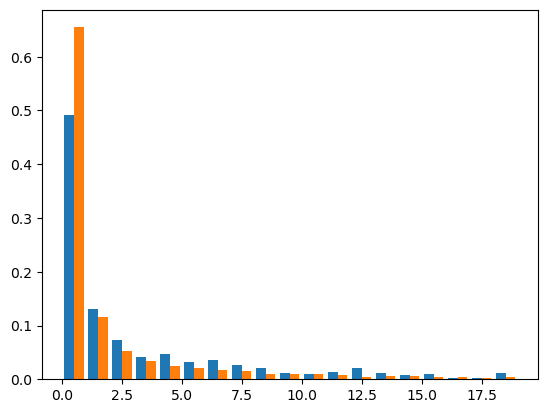

In [240]:
q = qs[2]

plt.hist(
    [
        testme.filter(pl.col("cM")<= q)["total_mismatches"],
        testme.filter(pl.col("cM")> q)["total_mismatches"]
    ],
    bins=np.arange(20),
    log=False,
    density=True,
);
        

## Test cM in random reads

In [241]:
%%time

def runme(focal_sample_id, chrom):
    df = (
        pl.scan_parquet(
            Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet"
        )
        .select(["read_name", 'total_mismatches', 'total_common_insertions', 'num_common_insertions', 'num_common_deletions', 'total_clipping', "read_length1"])
        .unique()
        .collect(streaming=True)
    )
    return df
        
errors_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(focal_sample_id, chrom) 
            for focal_sample_id in sample_ids for chrom in aut_chrom_names
    )
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.2min
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Par

CPU times: user 10.7 s, sys: 7.6 s, total: 18.3 s
Wall time: 5min 8s


In [242]:
errors_df

read_name,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,read_length1
str,i64,i64,u32,u32,i64,i32
"""m64094e_220917…",2,22,22,12,0,14095
"""m64094e_220917…",5,18,18,47,0,14715
"""m64230e_220906…",1,19,19,8,0,13455
"""m64178e_220829…",0,16,16,1,0,10984
"""m64230e_220906…",0,14,11,8,0,12689
…,…,…,…,…,…,…
"""m64094e_220717…",0,8,3,6,0,12607
"""m64174e_220620…",0,0,0,0,0,4930
"""m64094e_220715…",0,2,2,2,0,12017


In [243]:
testme_random = (all_annotated_random_df
    .filter(
        (pl.col("mapq") >= 60) & 
        (pl.col("is_forward1") == pl.col("is_forward2")) & 
        (pl.col("total_clipping") <= 10) &
        (pl.col("total_mismatches") <= 100)
    )
    .join(errors_df, on="read_name")
    .with_columns(
        normalized_total_mismatches = pl.col("total_mismatches") / pl.col("read_length1")
    )
)

In [244]:
print(testme_random["total_mismatches"].mean())
print(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_mismatches"].mean())


1.608029067706487
1.7900096061479347


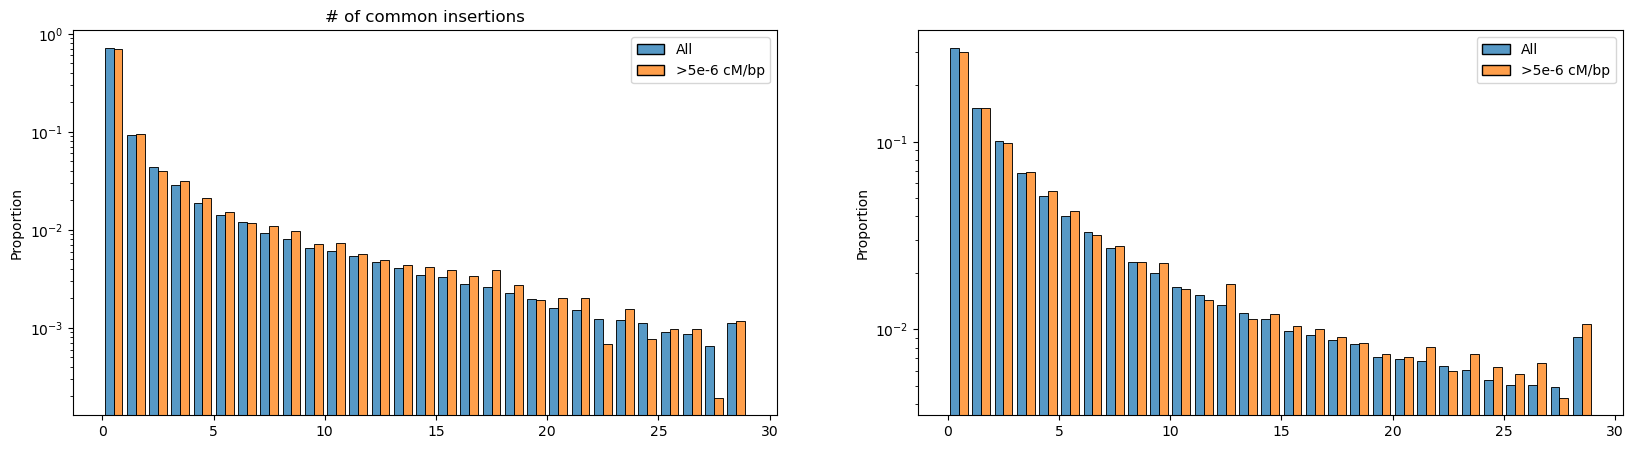

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_mismatches"], name=">5e-6 cM/bp"),
    ], 
    bins=np.arange(0, 30),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[0],
)

axs[0].set_yscale("log");
axs[0].set_title("# of common mismatches");
#plt.ylim(0,0.05);

sns.histplot(
    [
        pd.Series(testme_random["total_common_insertions"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_common_insertions"], name=">5e-6 cM/bp"),
    ], 
    bins=np.arange(0, 30),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[1],
)

axs[1].set_yscale("log");
axs[0].set_title("# of common insertions");
#plt.ylim(0,0.05);



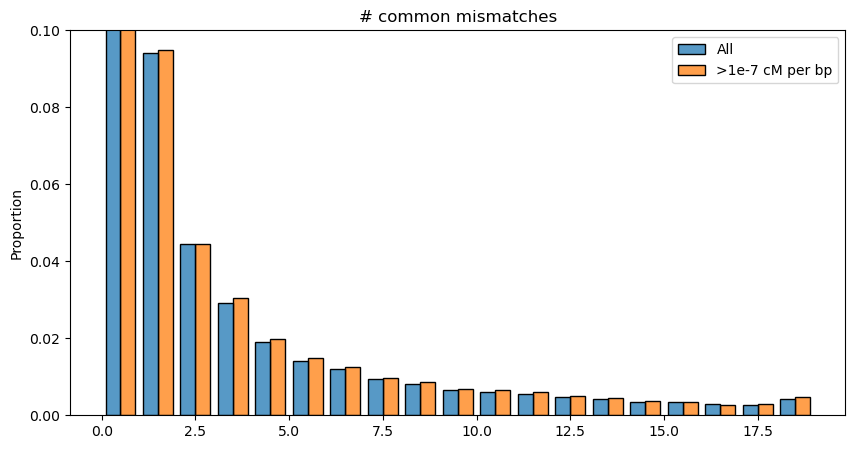

In [246]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 1e-7)["total_mismatches"], name=">1e-7 cM per bp"),
    ], 
    bins=np.arange(20),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("# common mismatches");
ax.set_ylim(0,0.1);


In [247]:
filtered_annotated_candidates_df_expanded

read_name,frac_fits1_super_conf,start_pos_0based,end_pos_0based,mapq,read_length,start_pos_cM,cM,prob_CO,cM_per_bp_across_read,sample_id,chrom,read_length_right,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom_denovo,active_start_pos,active_end_pos,active_region_length,active_start_pos_cM,active_end_pos_cM,active_cM,cM_per_bp_across_active
str,f64,i64,i64,i64,i64,f64,f64,f64,f64,str,str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,i64,i64,i64,f64,f64,f64,f64
"""m64178e_220829…",0.5,176432899,176446612,60,13711,128.763599,0.22569,0.002254,0.000016,"""PD50477f""","""chr1""",13711,1,[0],"[5519, 7278]","""ambiguous""",0,0,0,1,0,0,18,14,60,60,false,false,false,"""chr1_RagTag""",176438418,176440177,1759,128.809556,128.841486,0.03193,0.000018
"""m64178e_220829…",0.5,7161301,7174900,60,13569,16.921781,0.112327,0.001123,0.000008,"""PD50477f""","""chr1""",13569,1,[3],"[3191, 4854, … 8953]","""CO""",1,3,3,18,0,0,12,12,60,60,false,false,false,"""chr1_RagTag""",7168178,7169711,1533,16.922872,16.923238,0.000365,2.3841e-7
"""m64230e_220906…",0.111111,232718299,232731787,60,13492,165.58355,0.002323,0.000023,1.7219e-7,"""PD50477f""","""chr1""",13492,4,"[3, 4, … 18]","[1131, 1774, … 11034]","""CNCO""",19,6,3,3,0,0,13,12,60,60,false,false,false,"""chr1_RagTag""",232721836,232729333,7497,165.58415,165.584606,0.000456,6.0783e-8
"""m64094e_220917…",0.1,236534541,236543568,60,11136,170.22101,0.102945,0.001029,0.000009,"""PD50477f""","""chr1""",11136,1,[8],"[1630, 1745, … 10590]","""CO""",2,3,3,5,0,0,7,8,60,60,true,true,false,"""chr1_RagTag""",236543734,236543925,191,170.325867,170.328068,0.002201,0.000012
"""m64178e_220829…",0.974359,36853312,36872661,60,19355,46.402298,0.039658,0.000397,0.000002,"""PD50477f""","""chr1""",19355,2,"[3, 4]","[1722, 2383, … 18544]","""GC""",0,14,12,9,1,1,15,18,60,60,false,false,false,"""chr1_RagTag""",36857147,36858923,1776,46.417318,46.430679,0.013361,0.000008
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m64094e_220717…",0.666667,50167612,50191766,60,24294,59.350844,0.019327,0.000193,7.9555e-7,"""PD50489e""","""chr22""",24294,1,[3],"[651, 1542, … 22557]","""ambiguous""",0,7,7,43,0,0,3,5,60,60,true,true,false,"""chr22_RagTag""",50170246,50190169,19923,59.351698,59.369113,0.017414,8.7408e-7
"""m64094e_220715…",0.75,25052667,25063054,60,10389,12.620659,0.010649,0.000106,0.000001,"""PD50489e""","""chr22""",10389,1,[2],"[628, 1804, … 9167]","""CO""",0,1,1,2,0,0,9,6,60,60,true,true,false,"""chr22_RagTag""",25054860,25055238,378,12.62279,12.623157,0.000367,9.7161e-7
"""m64094e_220715…",0.25,null,null,null,null,null,null,null,null,"""PD50489e""","""chr22""",14367,2,"[4, 6]","[1089, 6349, … 10948]","""GC""",4,34,34,18,0,0,10,11,60,60,true,true,false,"""chr22_RagTag""",null,null,null,NaN,NaN,NaN,null


## Compare random reads to candidate reads

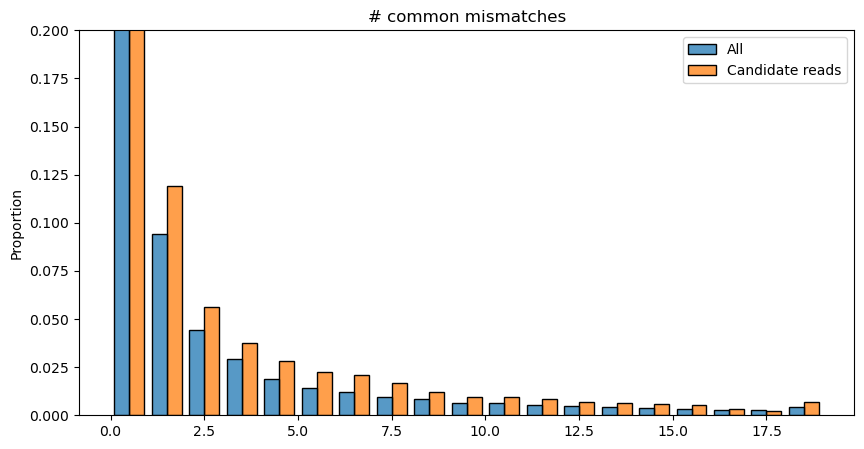

In [248]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded["total_mismatches"], name="Candidate reads"),
    ], 
    bins=np.arange(20),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("# common mismatches");
ax.set_ylim(0,0.2);


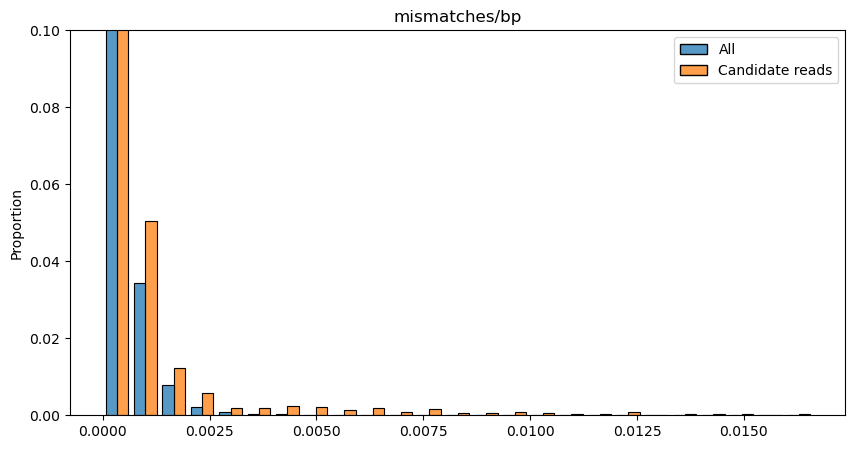

In [249]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["normalized_total_mismatches"], name="All"),
        pd.Series(
            filtered_annotated_candidates_df_expanded["total_mismatches"] / filtered_annotated_candidates_df_expanded["read_length"], 
            name="Candidate reads"
        ),
    ], 
    bins=25,
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("mismatches/bp");
ax.set_ylim(0,0.1);


# Compare seq errors vs. hotspots

In [250]:
testme_random_grch38 = (all_annotated_random_grch38_df
    .filter(
        (pl.col("mapq") >= 60) & 
        (pl.col("is_forward1") == pl.col("is_forward2")) & 
        (extra_filtering)
    )
    .join(errors_df, on="read_name")
    .with_columns(
        normalized_total_mismatches = pl.col("total_mismatches") / pl.col("read_length1"),
        AA_hotspot_in_read = (pl.col("start_pos_0based") <= pl.col("AA_motif_center_pos")) & (pl.col("AA_motif_center_pos") < pl.col("end_pos_0based")),
        CL4_hotspot_in_read = (pl.col("start_pos_0based") <= pl.col("CL4_motif_center_pos")) & (pl.col("CL4_motif_center_pos") < pl.col("end_pos_0based")),
    )
)

In [251]:
testme_random_grch38.columns

['read_name',
 'frac_fits1_more_snps_high_conf',
 'mapq1',
 'mapq2',
 'is_forward1',
 'is_forward2',
 'total_mismatches',
 'num_common_insertions',
 'num_common_deletions',
 'total_clipping',
 'start_pos_0based',
 'end_pos_0based',
 'mapq',
 'read_length',
 'start_pos_cM',
 'cM',
 'prob_CO',
 'cM_per_bp_across_read',
 'sample_id',
 'chrom',
 'AA_motif_center_pos',
 'AA_heat',
 'AA_motif_strand',
 'CL4_motif_center_pos',
 'CL4_heat',
 'CL4_motif_strand',
 'total_mismatches_right',
 'total_common_insertions',
 'num_common_insertions_right',
 'num_common_deletions_right',
 'total_clipping_right',
 'read_length1',
 'normalized_total_mismatches',
 'AA_hotspot_in_read',
 'CL4_hotspot_in_read']

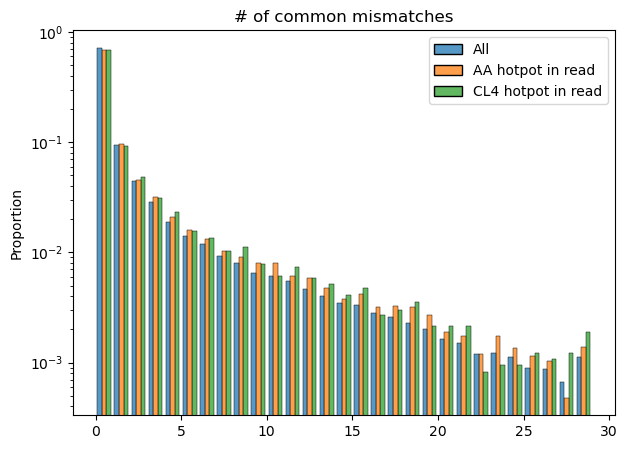

In [252]:
fig, ax = plt.subplots(figsize=(7,5))

sns.histplot(
    [
        pd.Series(testme_random_grch38["total_mismatches"], name="All"),
        pd.Series(testme_random_grch38.filter(pl.col("AA_hotspot_in_read"))["total_mismatches"], name="AA hotpot in read"),
        pd.Series(testme_random_grch38.filter(pl.col("CL4_hotspot_in_read"))["total_mismatches"], name="CL4 hotpot in read"),
    ], 
    bins=np.arange(0, 30),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

ax.set_yscale("log");
ax.set_title("# of common mismatches");

In [253]:
all_mm = testme_random_grch38["total_mismatches"]
AA_mm = testme_random_grch38.filter(pl.col("AA_hotspot_in_read"))["total_mismatches"]
CL4_mm = testme_random_grch38.filter(pl.col("CL4_hotspot_in_read"))["total_mismatches"]

In [254]:
print("All", all_mm.mean())
print("AA", AA_mm.mean())
print("CL4", CL4_mm.mean())

print(scipy.stats.ttest_ind(all_mm, AA_mm))
print(scipy.stats.ttest_ind(all_mm, CL4_mm))
print(scipy.stats.ttest_ind(AA_mm, CL4_mm))

print(scipy.stats.ks_2samp(all_mm, AA_mm))
print(scipy.stats.ks_2samp(all_mm, CL4_mm))
print(scipy.stats.ks_2samp(AA_mm, CL4_mm))

All 1.6102008560709604
AA 1.8791064910331694
CL4 1.9140972128719538
TtestResult(statistic=-8.253269001310718, pvalue=1.5502846532401385e-16, df=202991.0)
TtestResult(statistic=-5.340615608934053, pvalue=9.274028632728308e-08, df=185214.0)
TtestResult(statistic=-0.5085364289710808, pvalue=0.6110806364858253, df=32629.0)
KstestResult(statistic=0.027651367579751285, pvalue=4.267718756155136e-15, statistic_location=0, statistic_sign=1)
KstestResult(statistic=0.030466770487146078, pvalue=3.4952434751605537e-06, statistic_location=1, statistic_sign=1)
KstestResult(statistic=0.006456991840615878, pvalue=0.9692677885208467, statistic_location=1, statistic_sign=1)


# Complex events

In [255]:
complex_df = (very_trusty_cls_df
    .filter(pl.col("class") == "CNCO")
)

In [256]:
complex_df["n_transitions"].value_counts().sort("n_transitions")

n_transitions,count
i64,u32
3,76
4,71
5,27
6,30
7,22
…,…
11,6
12,2
13,3


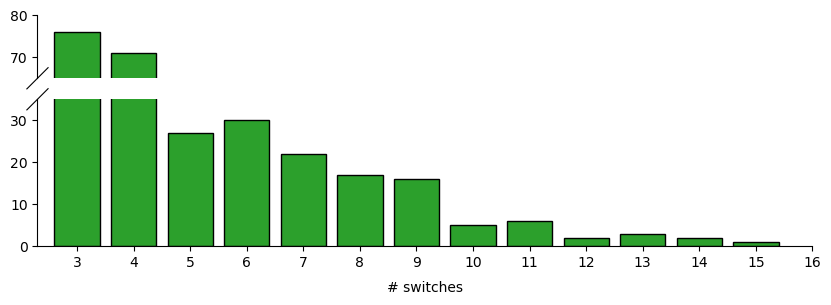

In [257]:
fig = plt.figure(figsize=(10,3))
bax = brokenaxes(xlims=((2.3, 15.5),), ylims=((0, 35), (65, 80)), hspace=0.2)

bax.bar(
    np.arange(3,17)[:-1],
    np.histogram(complex_df["n_transitions"], bins=np.arange(3,17))[0],
    align="center",
    color="C2",
    edgecolor='black', 
    linewidth=1,
);
bax.set_xlabel("# switches", labelpad=25);
bax.set_xticks(np.arange(3,17), np.arange(3,17));

In [258]:
complex_rows = (complex_df
    .filter(pl.col("n_transitions") >= 9)
    .select("idx_transitions", "snp_positions_on_read", "read_length")
    .rows(named=True)
)

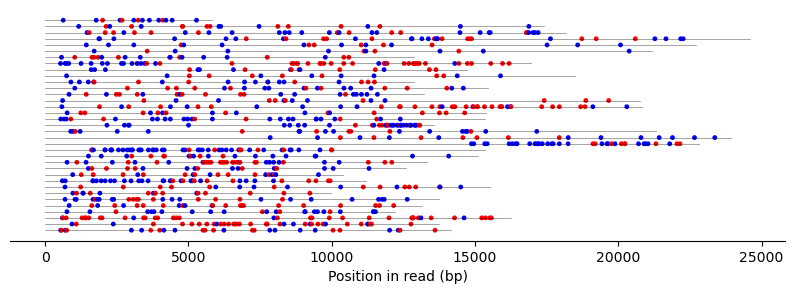

In [259]:
fig, ax = plt.subplots(figsize=(10, 3))

for i, row in enumerate(complex_rows):
    
    ax.plot(
        [0, row["read_length"]],
        [i,i],
        color="black",
        lw=0.5,
        alpha=0.5,
    )
    
    colors = [0]
    for j in range(1, len(row["snp_positions_on_read"])):
        if j in row["idx_transitions"]:
            colors.append(1-colors[-1])
        else:
            colors.append(colors[-1])
            
    ax.scatter(
        x = row["snp_positions_on_read"],
        y = [i] * len(row["snp_positions_on_read"]),
        s = 6,
        c = [["blue", "red"][x] for x in colors],
    )
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("Position in read (bp)");
ax.set_yticks([], []); #np.arange(len(complex_rows)), np.arange(len(complex_rows)), fontsize=7);